# Model
The model used in this experiment is a CNN consisting of two 1-D convolutional layers, followed by a global average pooling layer and a softmax layer. The convolutional layers have 32 and 64 filters each. 
A global average pooling layer is used instead of flattening and it significantly reduces the dimensionality of the input going into the softmax layer. This way fully connected layers are not always necessary and the number of parameters in the model are kept to a minimum. 

# Data
The model is trained on data from the lag growth phase using an integration time of 16ms. The model is classifying the species of a given bacteria sample.

In [1]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPool1D, GlobalAvgPool1D

In [2]:
os.getcwd()

'/home/anthony/summer-bursary-2018/bacteria'

In [3]:
os.listdir('data')

['Classific.py',
 'graphs.pdf',
 'growth_stages.csv',
 '16ms_32ms_growth_phase_spectra.csv',
 'bacteria_32ms.csv',
 'PC6allwavelengths.png',
 'bacteria_16ms.csv',
 'wavelengths.csv',
 '16_ms_lag_codes.csv',
 'bacteria.csv']

In [4]:
df_16ms = pd.read_csv('data/bacteria_16ms.csv', header=[0, 1, 2, 3], index_col=0)
df_16ms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 1042
Columns: 135 entries, (lag, positive, bc, 01) to (stat, negative, se, 07)
dtypes: float64(135)
memory usage: 1.1 MB


In [5]:
df_16ms.describe()

growth_phase          lag                                                      \
gramness         positive                                                       
species                bc                                                       
replicate              01           02           03           04           05   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           340.917966   218.282554   410.265450   402.411758   147.930946   
std            517.453981   328.263253   632.792734   584.358827   213.381498   
min             -3.510400    -2.800760    -2.581292    -2.554170    -2.985820   
25%              3.738191     2.116139     3.614560     4.258268     3.017208   
50%             40.780240    27.023980    48.616896    58.972290    24.396270   
75%            496.754350   319.173550   571.801010   629.260350   223.730650   
max           1649.755000  1044.867000  2050.509445  1755.384000   670.982500   

growth_phase                                                                   \
gramness                                                                        
species                                                                         
replicate              06           07           08           09           10   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           304.443366   690.243351   615.625463   508.217097   267.395909   
std            457.365956  1076.320701  1006.404767   829.675942   411.266389   
min             -3.429370    -2.280780    -4.327390    -3.340390   -24.324100   
25%              3.429760     4.382186     3.291279     3.093110    -1.435505   
50%             37.316280    78.138510    46.407810    41.594080    26.498390   
75%            446.739200   940.880800   775.154550   630.964700   401.714900   
max           1426.308000  3542.053000  3369.752000  2848.575000  1316.226000   

growth_phase     ...              stat                                         \
gramness         ...          positive                               negative   
species          ...                sa                                     se   
replicate        ...                06           07           08           01   
count            ...       1043.000000  1043.000000  1043.000000  1043.000000   
mean             ...       1319.282527  1617.105057  1424.455291   332.375709   
std              ...       2183.988762  2683.151537  2381.357464   525.271213   
min              ...        -18.529200    -2.563420    -1.462970    -2.361310   
25%              ...         11.080080    12.687795    10.883005     2.919165   
50%              ...        107.911900   130.242300   104.561900    33.991250   
75%              ...       1577.928000  1936.329500  1679.898000   436.948300   
max              ...       7512.713000  9235.687000  8223.580000  1713.175000   

growth_phase                                                                   \
gramness                                                                        
species                                                                         
replicate              02           03           04           05           06   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           464.757981   346.619581   591.019431   944.666722   683.460369   
std            783.676339   589.041597  1030.124114  1631.945511  1174.686894   
min             -3.337340    -2.003951    -2.814100    -3.369360    -3.098660   
25%              3.433975     2.271594     7.036556     5.055340     3.809488   
50%             34.734540    22.254616    41.866360    52.880860    42.561820   
75%            533.983350   395.229638   603.002400  1030.629000   753.640300   
max           2670.119000  2010.552740  3632.655000  5669.533000  4091.082000   

growth_phase               
gramness                   
species                    
replicate              0

In [6]:
X = df_16ms['lag'].T.values
# Scaling to [0.0, 1.0] improves convergence. 
# Relative scale between features are retained when done this way, rather than using sklearn's MinMaxScaler.
X = (X - X.min()) / (X.max() - X.min())

print(X.min(), X.max())
print(X[:5])

0.0 1.0
[[0.00450176 0.00479049 0.00463409 ... 0.0046341  0.00444161 0.00440552]
 [0.00461694 0.00411015 0.00451328 ... 0.00461694 0.00460543 0.00442113]
 [0.0045137  0.00462119 0.00431068 ... 0.0045973  0.00433457 0.00470479]
 [0.00429917 0.00402905 0.00433294 ... 0.00488443 0.00452427 0.00470436]
 [0.00422548 0.00439816 0.00504281 ... 0.00451327 0.00442118 0.00476653]]


In [7]:
X = np.expand_dims(X, axis=2)

print(X.shape)

(47, 1043, 1)


In [8]:
from sklearn.preprocessing import OneHotEncoder

y = df_16ms['lag'].T.reset_index()['species']
y = y.values
y = y.reshape(-1, 1)

y[:5]

array([['bc'],
       ['bc'],
       ['bc'],
       ['bc'],
       ['bc']], dtype=object)

In [9]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

X[:5]

array([[[0.00447872],
        [0.00457088],
        [0.0047667 ],
        ...,
        [0.00444416],
        [0.00449024],
        [0.0049395 ]],

       [[0.00436016],
        [0.00438378],
        [0.00420675],
        ...,
        [0.00513912],
        [0.00559929],
        [0.00295443]],

       [[0.00427999],
        [0.00480802],
        [0.0041427 ],
        ...,
        [0.00460737],
        [0.00452288],
        [0.00433279]],

       [[0.00456261],
        [0.00447742],
        [0.00441657],
        ...,
        [0.00430705],
        [0.00422186],
        [0.00457478]],

       [[0.00449038],
        [0.00470672],
        [0.00447899],
        ...,
        [0.00436512],
        [0.00454731],
        [0.0044676 ]]])

In [10]:
y[:5]

array([['pa'],
       ['sa'],
       ['pa'],
       ['se'],
       ['lm']], dtype=object)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(37, 1043, 1) (10, 1043, 1)
(37, 1) (10, 1)


In [12]:
N = X_train.shape[0]
W = X_train.shape[1]
C = X_train.shape[2]
print(N, W, C)

37 1043 1


In [13]:
k = len(np.unique(y))
print(k)

6


In [14]:
def get_model():
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='elu', input_shape=(W, C)))
    model.add(Conv1D(64, kernel_size=3, activation='elu'))

    model.add(GlobalAvgPool1D())
    model.add(Dense(k, activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

    return model

In [15]:
model = get_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,)

ohe = OneHotEncoder(sparse=False)
y_train_encoded = ohe.fit_transform(y_train)
y_test_encoded = ohe.fit_transform(y_test)

history = model.fit(X_train, y_train_encoded,
          epochs=1000,
          validation_data=(X_test, y_test_encoded),
         callbacks=[early_stopping])

score = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Test loss: %.2f' % score[0])
print('Test accuracy: %.2f' % score[1])

Train on 37 samples, validate on 10 samples
Epoch 1/1000
37/37 [==============================] - 2s 57ms/step - loss: 1.7900 - acc: 0.1622 - val_loss: 1.7698 - val_acc: 0.2000
Epoch 2/1000
37/37 [==============================] - 0s 9ms/step - loss: 1.7676 - acc: 0.2432 - val_loss: 1.7680 - val_acc: 0.2000
Epoch 3/1000
37/37 [==============================] - 0s 5ms/step - loss: 1.7627 - acc: 0.2432 - val_loss: 1.7584 - val_acc: 0.2000
Epoch 4/1000
37/37 [==============================] - 1s 16ms/step - loss: 1.7570 - acc: 0.2432 - val_loss: 1.7593 - val_acc: 0.2000
Epoch 5/1000
37/37 [==============================] - 1s 19ms/step - loss: 1.7554 - acc: 0.2432 - val_loss: 1.7552 - val_acc: 0.2000
Epoch 6/1000
37/37 [==============================] - 0s 12ms/step - loss: 1.7513 - acc: 0.2703 - val_loss: 1.7503 - val_acc: 0.2000
Epoch 7/1000
37/37 [==============================] - 0s 3ms/step - loss: 1.7485 - acc: 0.3243 - val_loss: 1.7433 - val_acc: 0.4000
Epoch 8/1000
37/37 [========

37/37 [==============================] - 0s 7ms/step - loss: 1.4886 - acc: 0.4324 - val_loss: 1.5553 - val_acc: 0.4000
Epoch 63/1000
37/37 [==============================] - 0s 7ms/step - loss: 1.4834 - acc: 0.4324 - val_loss: 1.5540 - val_acc: 0.4000
Epoch 64/1000
37/37 [==============================] - 0s 7ms/step - loss: 1.4775 - acc: 0.4324 - val_loss: 1.5502 - val_acc: 0.4000
Epoch 65/1000
37/37 [==============================] - 0s 7ms/step - loss: 1.4745 - acc: 0.4324 - val_loss: 1.5492 - val_acc: 0.4000
Epoch 66/1000
37/37 [==============================] - 0s 7ms/step - loss: 1.4715 - acc: 0.4595 - val_loss: 1.5498 - val_acc: 0.4000
Epoch 67/1000
37/37 [==============================] - 0s 6ms/step - loss: 1.4694 - acc: 0.4324 - val_loss: 1.5416 - val_acc: 0.4000
Epoch 68/1000
37/37 [==============================] - 0s 7ms/step - loss: 1.4615 - acc: 0.4324 - val_loss: 1.5409 - val_acc: 0.4000
Epoch 69/1000
37/37 [==============================] - 0s 5ms/step - loss: 1.4596 -

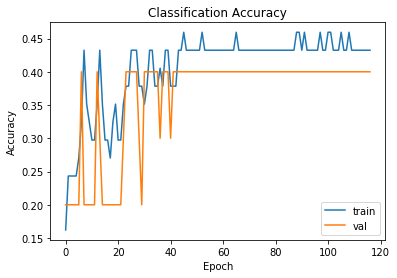

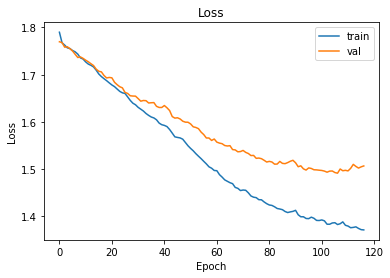

In [16]:
import matplotlib.pyplot as plt

%matplotlib inline

acc_history = history.history['acc']
val_acc_history = history.history['val_acc']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

epochs = np.arange(len(acc_history))

plt.plot(epochs, acc_history, label='train')
plt.plot(epochs, val_acc_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy')
plt.legend()
plt.show()


plt.plot(epochs, loss_history, label='train')
plt.plot(epochs, val_loss_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [17]:
%%time

from sklearn.model_selection import RepeatedStratifiedKFold

n_splits = 3
n_repeats = 20
n_total = n_splits * n_repeats
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

score_history = []

print('Fitting %d folds over %d repetitions for a total of %d fits.' % (n_splits, n_repeats, n_total))

for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('\nIteration %d of %d' % (i + 1, n_total))
    
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_val_cv = X[val_idx]
    y_val_cv= y[val_idx]

    # Encoding is not done directly on y so that the k-fold splitter doesn't throw an exception.
    ohe = OneHotEncoder(sparse=False)
    y_train_cv = ohe.fit_transform(y_train_cv)
    y_val_cv = ohe.fit_transform(y_val_cv)
    
    model = get_model() 

    history = model.fit(X_train_cv, y_train_cv,
              epochs=100,
              validation_data=(X_val_cv, y_val_cv))
    
    score_history.append(history.history)

    score = model.evaluate(X_val_cv, y_val_cv, verbose=0)
    print('Validation loss: %.2f' % score[0])
    print('Validation accuracy: %.2f' % score[1])

Fitting 3 folds over 20 repetitions for a total of 60 fits.

Iteration 1 of 60
Train on 30 samples, validate on 17 samples
Epoch 1/100
30/30 [==============================] - 1s 30ms/step - loss: 1.8004 - acc: 0.1000 - val_loss: 1.7794 - val_acc: 0.2353
Epoch 2/100
30/30 [==============================] - 0s 8ms/step - loss: 1.7746 - acc: 0.2667 - val_loss: 1.7659 - val_acc: 0.4118
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7578 - acc: 0.4000 - val_loss: 1.7553 - val_acc: 0.4706
Epoch 4/100
30/30 [==============================] - 0s 6ms/step - loss: 1.7442 - acc: 0.4000 - val_loss: 1.7465 - val_acc: 0.4118
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7329 - acc: 0.3333 - val_loss: 1.7392 - val_acc: 0.3529
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7233 - acc: 0.3000 - val_loss: 1.7331 - val_acc: 0.3529
Epoch 7/100
30/30 [==============================] - 0s 9ms/step - loss: 1.7152 - acc: 0.2

Epoch 63/100
30/30 [==============================] - 0s 7ms/step - loss: 1.4152 - acc: 0.5000 - val_loss: 1.4887 - val_acc: 0.4118
Epoch 64/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4115 - acc: 0.5000 - val_loss: 1.4864 - val_acc: 0.4118
Epoch 65/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4079 - acc: 0.5000 - val_loss: 1.4842 - val_acc: 0.4118
Epoch 66/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4044 - acc: 0.5000 - val_loss: 1.4821 - val_acc: 0.4118
Epoch 67/100
30/30 [==============================] - 0s 7ms/step - loss: 1.4009 - acc: 0.5000 - val_loss: 1.4802 - val_acc: 0.4118
Epoch 68/100
30/30 [==============================] - 0s 10ms/step - loss: 1.3975 - acc: 0.5000 - val_loss: 1.4782 - val_acc: 0.4118
Epoch 69/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3943 - acc: 0.5000 - val_loss: 1.4770 - val_acc: 0.4118
Epoch 70/100
30/30 [==============================] - 0s 9ms/step - loss: 1

Epoch 25/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6147 - acc: 0.4667 - val_loss: 1.6406 - val_acc: 0.3529
Epoch 26/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6090 - acc: 0.4667 - val_loss: 1.6356 - val_acc: 0.4118
Epoch 27/100
30/30 [==============================] - 0s 7ms/step - loss: 1.6033 - acc: 0.4667 - val_loss: 1.6305 - val_acc: 0.4118
Epoch 28/100
30/30 [==============================] - 0s 7ms/step - loss: 1.5975 - acc: 0.4667 - val_loss: 1.6254 - val_acc: 0.4118
Epoch 29/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5916 - acc: 0.4667 - val_loss: 1.6202 - val_acc: 0.4118
Epoch 30/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5857 - acc: 0.4667 - val_loss: 1.6150 - val_acc: 0.4118
Epoch 31/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5798 - acc: 0.4333 - val_loss: 1.6098 - val_acc: 0.4118
Epoch 32/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.3575 - acc: 0.4333 - val_loss: 1.5205 - val_acc: 0.4118
Epoch 88/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3558 - acc: 0.4333 - val_loss: 1.5077 - val_acc: 0.4118
Epoch 89/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3542 - acc: 0.4333 - val_loss: 1.5248 - val_acc: 0.4118
Epoch 90/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3527 - acc: 0.4333 - val_loss: 1.5085 - val_acc: 0.4118
Epoch 91/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3513 - acc: 0.4333 - val_loss: 1.5304 - val_acc: 0.4118
Epoch 92/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3500 - acc: 0.4333 - val_loss: 1.5091 - val_acc: 0.4118
Epoch 93/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3487 - acc: 0.4333 - val_loss: 1.5355 - val_acc: 0.4118
Epoch 94/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3474 - acc: 0

34/34 [==============================] - 0s 5ms/step - loss: 1.6242 - acc: 0.3529 - val_loss: 1.6465 - val_acc: 0.4615
Epoch 49/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6212 - acc: 0.3529 - val_loss: 1.6400 - val_acc: 0.4615
Epoch 50/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6181 - acc: 0.4118 - val_loss: 1.6355 - val_acc: 0.4615
Epoch 51/100
34/34 [==============================] - 0s 4ms/step - loss: 1.6160 - acc: 0.4118 - val_loss: 1.6351 - val_acc: 0.4615
Epoch 52/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6128 - acc: 0.4118 - val_loss: 1.6396 - val_acc: 0.4615
Epoch 53/100
34/34 [==============================] - 0s 8ms/step - loss: 1.6119 - acc: 0.4118 - val_loss: 1.6438 - val_acc: 0.4615
Epoch 54/100
34/34 [==============================] - 0s 8ms/step - loss: 1.6106 - acc: 0.4118 - val_loss: 1.6387 - val_acc: 0.4615
Epoch 55/100
34/34 [==============================] - 0s 8ms/step - loss: 1.6067 - acc: 0

Epoch 10/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6999 - acc: 0.2333 - val_loss: 1.7380 - val_acc: 0.2353
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6969 - acc: 0.2333 - val_loss: 1.7367 - val_acc: 0.2941
Epoch 12/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6942 - acc: 0.2333 - val_loss: 1.7353 - val_acc: 0.2941
Epoch 13/100
30/30 [==============================] - 0s 8ms/step - loss: 1.6916 - acc: 0.2333 - val_loss: 1.7336 - val_acc: 0.2941
Epoch 14/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6891 - acc: 0.2333 - val_loss: 1.7317 - val_acc: 0.2941
Epoch 15/100
30/30 [==============================] - 0s 7ms/step - loss: 1.6866 - acc: 0.2667 - val_loss: 1.7296 - val_acc: 0.2941
Epoch 16/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6839 - acc: 0.2667 - val_loss: 1.7272 - val_acc: 0.2941
Epoch 17/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.4250 - acc: 0.4333 - val_loss: 1.4628 - val_acc: 0.4706
Epoch 73/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4220 - acc: 0.4000 - val_loss: 1.4597 - val_acc: 0.4706
Epoch 74/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4190 - acc: 0.4333 - val_loss: 1.4585 - val_acc: 0.4706
Epoch 75/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4162 - acc: 0.4000 - val_loss: 1.4559 - val_acc: 0.4706
Epoch 76/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4134 - acc: 0.4333 - val_loss: 1.4550 - val_acc: 0.4706
Epoch 77/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4107 - acc: 0.4000 - val_loss: 1.4526 - val_acc: 0.4706
Epoch 78/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4081 - acc: 0.4333 - val_loss: 1.4524 - val_acc: 0.4706
Epoch 79/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4055 - acc: 0

Epoch 34/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5099 - acc: 0.4667 - val_loss: 1.5952 - val_acc: 0.4118
Epoch 35/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5027 - acc: 0.4667 - val_loss: 1.5912 - val_acc: 0.4118
Epoch 36/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4957 - acc: 0.4667 - val_loss: 1.5874 - val_acc: 0.4118
Epoch 37/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4888 - acc: 0.4667 - val_loss: 1.5836 - val_acc: 0.4118
Epoch 38/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4821 - acc: 0.4667 - val_loss: 1.5799 - val_acc: 0.4118
Epoch 39/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4756 - acc: 0.4667 - val_loss: 1.5764 - val_acc: 0.4118
Epoch 40/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4692 - acc: 0.4667 - val_loss: 1.5730 - val_acc: 0.4118
Epoch 41/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.3177 - acc: 0.4667 - val_loss: 1.5265 - val_acc: 0.3529
Epoch 97/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3172 - acc: 0.4667 - val_loss: 1.5748 - val_acc: 0.3529
Epoch 98/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3167 - acc: 0.4667 - val_loss: 1.5274 - val_acc: 0.3529
Epoch 99/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3161 - acc: 0.4667 - val_loss: 1.5751 - val_acc: 0.3529
Epoch 100/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3154 - acc: 0.4667 - val_loss: 1.5319 - val_acc: 0.3529
Validation loss: 1.53
Validation accuracy: 0.35

Iteration 6 of 60
Train on 34 samples, validate on 13 samples
Epoch 1/100
34/34 [==============================] - 1s 32ms/step - loss: 1.7921 - acc: 0.1176 - val_loss: 1.7692 - val_acc: 0.4615
Epoch 2/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7722 - acc: 0.4412 - val_loss: 1.7

34/34 [==============================] - 0s 5ms/step - loss: 1.5482 - acc: 0.3824 - val_loss: 1.5648 - val_acc: 0.3077
Epoch 58/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5438 - acc: 0.4118 - val_loss: 1.5568 - val_acc: 0.3846
Epoch 59/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5402 - acc: 0.4412 - val_loss: 1.5850 - val_acc: 0.3846
Epoch 60/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5420 - acc: 0.4118 - val_loss: 1.5682 - val_acc: 0.3846
Epoch 61/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5346 - acc: 0.4706 - val_loss: 1.5473 - val_acc: 0.3846
Epoch 62/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5301 - acc: 0.4706 - val_loss: 1.5315 - val_acc: 0.4615
Epoch 63/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5264 - acc: 0.4412 - val_loss: 1.5267 - val_acc: 0.4615
Epoch 64/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5244 - acc: 0

Epoch 19/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6369 - acc: 0.4333 - val_loss: 1.6742 - val_acc: 0.4118
Epoch 20/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6309 - acc: 0.4333 - val_loss: 1.6698 - val_acc: 0.4706
Epoch 21/100
30/30 [==============================] - 0s 8ms/step - loss: 1.6248 - acc: 0.4333 - val_loss: 1.6652 - val_acc: 0.4706
Epoch 22/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6185 - acc: 0.4333 - val_loss: 1.6606 - val_acc: 0.4118
Epoch 23/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6121 - acc: 0.4333 - val_loss: 1.6559 - val_acc: 0.4118
Epoch 24/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6056 - acc: 0.4333 - val_loss: 1.6512 - val_acc: 0.4118
Epoch 25/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5989 - acc: 0.4333 - val_loss: 1.6464 - val_acc: 0.4118
Epoch 26/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

30/30 [==============================] - 0s 4ms/step - loss: 1.3336 - acc: 0.4667 - val_loss: 1.5121 - val_acc: 0.4118
Epoch 82/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3313 - acc: 0.4667 - val_loss: 1.5030 - val_acc: 0.4118
Epoch 83/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3292 - acc: 0.4667 - val_loss: 1.5178 - val_acc: 0.4118
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3272 - acc: 0.4667 - val_loss: 1.4993 - val_acc: 0.4118
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3255 - acc: 0.4667 - val_loss: 1.5230 - val_acc: 0.4118
Epoch 86/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3236 - acc: 0.4667 - val_loss: 1.5005 - val_acc: 0.4118
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3214 - acc: 0.4667 - val_loss: 1.5211 - val_acc: 0.4118
Epoch 88/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3192 - acc: 0

Epoch 43/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4852 - acc: 0.4667 - val_loss: 1.5804 - val_acc: 0.3529
Epoch 44/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4787 - acc: 0.4667 - val_loss: 1.5775 - val_acc: 0.3529
Epoch 45/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4723 - acc: 0.4667 - val_loss: 1.5749 - val_acc: 0.3529
Epoch 46/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4659 - acc: 0.4667 - val_loss: 1.5726 - val_acc: 0.3529
Epoch 47/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4597 - acc: 0.4667 - val_loss: 1.5704 - val_acc: 0.3529
Epoch 48/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4535 - acc: 0.4667 - val_loss: 1.5685 - val_acc: 0.3529
Epoch 49/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4475 - acc: 0.4667 - val_loss: 1.5669 - val_acc: 0.3529
Epoch 50/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

34/34 [==============================] - 0s 5ms/step - loss: 1.7668 - acc: 0.2353 - val_loss: 1.7479 - val_acc: 0.3077
Epoch 5/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7613 - acc: 0.2647 - val_loss: 1.7380 - val_acc: 0.2308
Epoch 6/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7533 - acc: 0.2353 - val_loss: 1.7202 - val_acc: 0.2308
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7437 - acc: 0.2353 - val_loss: 1.7180 - val_acc: 0.2308
Epoch 8/100
34/34 [==============================] - 0s 4ms/step - loss: 1.7417 - acc: 0.2647 - val_loss: 1.7170 - val_acc: 0.2308
Epoch 9/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7414 - acc: 0.2647 - val_loss: 1.7036 - val_acc: 0.2308
Epoch 10/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7346 - acc: 0.2647 - val_loss: 1.6980 - val_acc: 0.2308
Epoch 11/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7302 - acc: 0.2353

34/34 [==============================] - 0s 5ms/step - loss: 1.6352 - acc: 0.3824 - val_loss: 1.5460 - val_acc: 0.5385
Epoch 67/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6321 - acc: 0.3824 - val_loss: 1.5411 - val_acc: 0.5385
Epoch 68/100
34/34 [==============================] - 0s 8ms/step - loss: 1.6294 - acc: 0.3824 - val_loss: 1.5402 - val_acc: 0.5385
Epoch 69/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6265 - acc: 0.3824 - val_loss: 1.5336 - val_acc: 0.5385
Epoch 70/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6248 - acc: 0.3824 - val_loss: 1.5317 - val_acc: 0.5385
Epoch 71/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6255 - acc: 0.4118 - val_loss: 1.5231 - val_acc: 0.5385
Epoch 72/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6210 - acc: 0.3824 - val_loss: 1.5198 - val_acc: 0.5385
Epoch 73/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6194 - acc: 0

Epoch 28/100
30/30 [==============================] - 0s 7ms/step - loss: 1.5907 - acc: 0.4333 - val_loss: 1.6435 - val_acc: 0.4118
Epoch 29/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5838 - acc: 0.4333 - val_loss: 1.6391 - val_acc: 0.4118
Epoch 30/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5769 - acc: 0.4333 - val_loss: 1.6348 - val_acc: 0.4118
Epoch 31/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5700 - acc: 0.4333 - val_loss: 1.6305 - val_acc: 0.4118
Epoch 32/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5630 - acc: 0.4333 - val_loss: 1.6262 - val_acc: 0.4118
Epoch 33/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5560 - acc: 0.4333 - val_loss: 1.6219 - val_acc: 0.4118
Epoch 34/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5490 - acc: 0.4333 - val_loss: 1.6178 - val_acc: 0.4118
Epoch 35/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

30/30 [==============================] - 0s 6ms/step - loss: 1.2942 - acc: 0.4333 - val_loss: 1.5951 - val_acc: 0.4118
Epoch 91/100
30/30 [==============================] - 0s 6ms/step - loss: 1.2920 - acc: 0.4333 - val_loss: 1.6055 - val_acc: 0.4118
Epoch 92/100
30/30 [==============================] - 0s 6ms/step - loss: 1.2898 - acc: 0.4333 - val_loss: 1.6011 - val_acc: 0.4118
Epoch 93/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2877 - acc: 0.4333 - val_loss: 1.6127 - val_acc: 0.4118
Epoch 94/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2856 - acc: 0.4333 - val_loss: 1.6067 - val_acc: 0.4118
Epoch 95/100
30/30 [==============================] - 0s 6ms/step - loss: 1.2837 - acc: 0.4333 - val_loss: 1.6211 - val_acc: 0.4118
Epoch 96/100
30/30 [==============================] - 0s 9ms/step - loss: 1.2818 - acc: 0.4333 - val_loss: 1.6122 - val_acc: 0.4118
Epoch 97/100
30/30 [==============================] - 0s 6ms/step - loss: 1.2800 - acc: 0

Epoch 52/100
30/30 [==============================] - 0s 12ms/step - loss: 1.4403 - acc: 0.4667 - val_loss: 1.5853 - val_acc: 0.4118
Epoch 53/100
30/30 [==============================] - 0s 12ms/step - loss: 1.4351 - acc: 0.4667 - val_loss: 1.5842 - val_acc: 0.4118
Epoch 54/100
30/30 [==============================] - 0s 11ms/step - loss: 1.4299 - acc: 0.4667 - val_loss: 1.5833 - val_acc: 0.4118
Epoch 55/100
30/30 [==============================] - 0s 11ms/step - loss: 1.4249 - acc: 0.4667 - val_loss: 1.5826 - val_acc: 0.4118
Epoch 56/100
30/30 [==============================] - 0s 12ms/step - loss: 1.4199 - acc: 0.4667 - val_loss: 1.5820 - val_acc: 0.4118
Epoch 57/100
30/30 [==============================] - 0s 8ms/step - loss: 1.4150 - acc: 0.4667 - val_loss: 1.5817 - val_acc: 0.4118
Epoch 58/100
30/30 [==============================] - 0s 9ms/step - loss: 1.4103 - acc: 0.4667 - val_loss: 1.5814 - val_acc: 0.4118
Epoch 59/100
30/30 [==============================] - 0s 10ms/step - lo

34/34 [==============================] - 0s 4ms/step - loss: 1.7381 - acc: 0.4118 - val_loss: 1.7123 - val_acc: 0.4615
Epoch 14/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7371 - acc: 0.3529 - val_loss: 1.7007 - val_acc: 0.3846
Epoch 15/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7296 - acc: 0.2647 - val_loss: 1.7020 - val_acc: 0.3846
Epoch 16/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7310 - acc: 0.2647 - val_loss: 1.6955 - val_acc: 0.4615
Epoch 17/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7291 - acc: 0.4412 - val_loss: 1.6948 - val_acc: 0.5385
Epoch 18/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7282 - acc: 0.4118 - val_loss: 1.6857 - val_acc: 0.4615
Epoch 19/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7236 - acc: 0.4118 - val_loss: 1.6797 - val_acc: 0.3846
Epoch 20/100
34/34 [==============================] - 0s 4ms/step - loss: 1.7193 - acc: 0

34/34 [==============================] - 0s 9ms/step - loss: 1.6260 - acc: 0.3824 - val_loss: 1.5537 - val_acc: 0.4615
Epoch 76/100
34/34 [==============================] - 0s 8ms/step - loss: 1.6246 - acc: 0.3824 - val_loss: 1.5406 - val_acc: 0.5385
Epoch 77/100
34/34 [==============================] - 0s 7ms/step - loss: 1.6161 - acc: 0.4118 - val_loss: 1.5434 - val_acc: 0.4615
Epoch 78/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6160 - acc: 0.3824 - val_loss: 1.5436 - val_acc: 0.5385
Epoch 79/100
34/34 [==============================] - 0s 7ms/step - loss: 1.6124 - acc: 0.4118 - val_loss: 1.5386 - val_acc: 0.4615
Epoch 80/100
34/34 [==============================] - 0s 7ms/step - loss: 1.6103 - acc: 0.4118 - val_loss: 1.5282 - val_acc: 0.5385
Epoch 81/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6010 - acc: 0.4118 - val_loss: 1.5241 - val_acc: 0.5385
Epoch 82/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6007 - acc: 0

Epoch 37/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5564 - acc: 0.4000 - val_loss: 1.5380 - val_acc: 0.4706
Epoch 38/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5510 - acc: 0.4000 - val_loss: 1.5316 - val_acc: 0.4706
Epoch 39/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5457 - acc: 0.4000 - val_loss: 1.5252 - val_acc: 0.4706
Epoch 40/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5405 - acc: 0.4000 - val_loss: 1.5189 - val_acc: 0.4706
Epoch 41/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5354 - acc: 0.4000 - val_loss: 1.5126 - val_acc: 0.4706
Epoch 42/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5304 - acc: 0.4000 - val_loss: 1.5065 - val_acc: 0.4706
Epoch 43/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5255 - acc: 0.4000 - val_loss: 1.5004 - val_acc: 0.4706
Epoch 44/100
30/30 [==============================] - 0s 7ms/step - loss: 1.

30/30 [==============================] - 0s 6ms/step - loss: 1.4045 - acc: 0.4333 - val_loss: 1.3301 - val_acc: 0.4706
Epoch 100/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4036 - acc: 0.4000 - val_loss: 1.3424 - val_acc: 0.4706
Validation loss: 1.34
Validation accuracy: 0.47

Iteration 14 of 60
Train on 30 samples, validate on 17 samples
Epoch 1/100
30/30 [==============================] - 2s 56ms/step - loss: 1.7901 - acc: 0.2333 - val_loss: 1.7693 - val_acc: 0.2353
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7673 - acc: 0.2333 - val_loss: 1.7567 - val_acc: 0.2353
Epoch 3/100
30/30 [==============================] - 0s 6ms/step - loss: 1.7519 - acc: 0.2333 - val_loss: 1.7470 - val_acc: 0.2353
Epoch 4/100
30/30 [==============================] - 0s 6ms/step - loss: 1.7389 - acc: 0.2333 - val_loss: 1.7393 - val_acc: 0.2353
Epoch 5/100
30/30 [==============================] - 0s 6ms/step - loss: 1.7276 - acc: 0.2333 - val_loss: 1.733

Epoch 61/100
30/30 [==============================] - 0s 7ms/step - loss: 1.3900 - acc: 0.4333 - val_loss: 1.5508 - val_acc: 0.4118
Epoch 62/100
30/30 [==============================] - 0s 7ms/step - loss: 1.3850 - acc: 0.4333 - val_loss: 1.5501 - val_acc: 0.4118
Epoch 63/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3800 - acc: 0.4333 - val_loss: 1.5544 - val_acc: 0.4118
Epoch 64/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3752 - acc: 0.4333 - val_loss: 1.5442 - val_acc: 0.4118
Epoch 65/100
30/30 [==============================] - 0s 8ms/step - loss: 1.3707 - acc: 0.4333 - val_loss: 1.5751 - val_acc: 0.4118
Epoch 66/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3674 - acc: 0.4333 - val_loss: 1.5382 - val_acc: 0.4118
Epoch 67/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3629 - acc: 0.4333 - val_loss: 1.5730 - val_acc: 0.4118
Epoch 68/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

34/34 [==============================] - 0s 5ms/step - loss: 1.6937 - acc: 0.2647 - val_loss: 1.6848 - val_acc: 0.2308
Epoch 23/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6899 - acc: 0.2353 - val_loss: 1.6838 - val_acc: 0.2308
Epoch 24/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6877 - acc: 0.2353 - val_loss: 1.6875 - val_acc: 0.2308
Epoch 25/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6875 - acc: 0.2353 - val_loss: 1.6873 - val_acc: 0.2308
Epoch 26/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6856 - acc: 0.2353 - val_loss: 1.6903 - val_acc: 0.2308
Epoch 27/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6854 - acc: 0.2353 - val_loss: 1.6919 - val_acc: 0.2308
Epoch 28/100
34/34 [==============================] - 0s 8ms/step - loss: 1.6863 - acc: 0.2353 - val_loss: 1.6920 - val_acc: 0.2308
Epoch 29/100
34/34 [==============================] - 0s 9ms/step - loss: 1.6822 - acc: 0

34/34 [==============================] - 0s 5ms/step - loss: 1.4731 - acc: 0.4412 - val_loss: 1.5344 - val_acc: 0.3846
Epoch 85/100
34/34 [==============================] - 0s 5ms/step - loss: 1.4676 - acc: 0.4412 - val_loss: 1.5371 - val_acc: 0.3846
Epoch 86/100
34/34 [==============================] - 0s 5ms/step - loss: 1.4640 - acc: 0.4706 - val_loss: 1.5443 - val_acc: 0.3846
Epoch 87/100
34/34 [==============================] - 0s 9ms/step - loss: 1.4633 - acc: 0.4706 - val_loss: 1.5537 - val_acc: 0.3846
Epoch 88/100
34/34 [==============================] - 0s 8ms/step - loss: 1.4646 - acc: 0.4706 - val_loss: 1.5418 - val_acc: 0.3846
Epoch 89/100
34/34 [==============================] - 0s 5ms/step - loss: 1.4552 - acc: 0.4706 - val_loss: 1.5491 - val_acc: 0.3846
Epoch 90/100
34/34 [==============================] - 0s 5ms/step - loss: 1.4563 - acc: 0.4706 - val_loss: 1.5579 - val_acc: 0.3077
Epoch 91/100
34/34 [==============================] - 0s 5ms/step - loss: 1.4563 - acc: 0

Epoch 46/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5205 - acc: 0.4000 - val_loss: 1.4661 - val_acc: 0.4706
Epoch 47/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5161 - acc: 0.4000 - val_loss: 1.4607 - val_acc: 0.4706
Epoch 48/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5118 - acc: 0.4000 - val_loss: 1.4554 - val_acc: 0.4706
Epoch 49/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5075 - acc: 0.4000 - val_loss: 1.4503 - val_acc: 0.4706
Epoch 50/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5034 - acc: 0.4000 - val_loss: 1.4453 - val_acc: 0.4706
Epoch 51/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4994 - acc: 0.4000 - val_loss: 1.4405 - val_acc: 0.4706
Epoch 52/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4954 - acc: 0.4000 - val_loss: 1.4359 - val_acc: 0.4706
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6862 - acc: 0.2667 - val_loss: 1.7269 - val_acc: 0.2353
Epoch 9/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6769 - acc: 0.3000 - val_loss: 1.7233 - val_acc: 0.2941
Epoch 10/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6681 - acc: 0.3000 - val_loss: 1.7199 - val_acc: 0.2941
Epoch 11/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6595 - acc: 0.3333 - val_loss: 1.7168 - val_acc: 0.2941
Epoch 12/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6512 - acc: 0.3333 - val_loss: 1.7139 - val_acc: 0.3529
Epoch 13/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6430 - acc: 0.3667 - val_loss: 1.7109 - val_acc: 0.3529
Epoch 14/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6349 - acc: 0.4000 - val_loss: 1.7081 - val_acc: 0.3529
Epoch 15/100
30/30 [==============================] - 0s 5ms/step - loss: 1.62

30/30 [==============================] - 0s 4ms/step - loss: 1.2770 - acc: 0.4667 - val_loss: 1.6078 - val_acc: 0.3529
Epoch 71/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2737 - acc: 0.4667 - val_loss: 1.6054 - val_acc: 0.3529
Epoch 72/100
30/30 [==============================] - 0s 4ms/step - loss: 1.2705 - acc: 0.4667 - val_loss: 1.6177 - val_acc: 0.3529
Epoch 73/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2681 - acc: 0.4667 - val_loss: 1.6029 - val_acc: 0.3529
Epoch 74/100
30/30 [==============================] - 0s 4ms/step - loss: 1.2657 - acc: 0.4667 - val_loss: 1.6219 - val_acc: 0.3529
Epoch 75/100
30/30 [==============================] - 0s 4ms/step - loss: 1.2624 - acc: 0.4667 - val_loss: 1.6083 - val_acc: 0.3529
Epoch 76/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2590 - acc: 0.4667 - val_loss: 1.6189 - val_acc: 0.3529
Epoch 77/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2560 - acc: 0

34/34 [==============================] - 0s 5ms/step - loss: 1.6992 - acc: 0.2353 - val_loss: 1.6657 - val_acc: 0.3077
Epoch 32/100
34/34 [==============================] - 0s 8ms/step - loss: 1.6982 - acc: 0.2647 - val_loss: 1.6619 - val_acc: 0.3077
Epoch 33/100
34/34 [==============================] - 0s 4ms/step - loss: 1.6954 - acc: 0.2353 - val_loss: 1.6582 - val_acc: 0.3077
Epoch 34/100
34/34 [==============================] - 0s 4ms/step - loss: 1.6944 - acc: 0.2647 - val_loss: 1.6562 - val_acc: 0.3077
Epoch 35/100
34/34 [==============================] - 0s 4ms/step - loss: 1.6928 - acc: 0.2647 - val_loss: 1.6471 - val_acc: 0.3077
Epoch 36/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6900 - acc: 0.2353 - val_loss: 1.6369 - val_acc: 0.3077
Epoch 37/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6886 - acc: 0.2353 - val_loss: 1.6378 - val_acc: 0.3077
Epoch 38/100
34/34 [==============================] - 0s 4ms/step - loss: 1.6897 - acc: 0

34/34 [==============================] - 0s 5ms/step - loss: 1.5359 - acc: 0.4118 - val_loss: 1.4609 - val_acc: 0.4615
Epoch 94/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5355 - acc: 0.4118 - val_loss: 1.4540 - val_acc: 0.4615
Epoch 95/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5324 - acc: 0.4118 - val_loss: 1.4477 - val_acc: 0.4615
Epoch 96/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5324 - acc: 0.4118 - val_loss: 1.4436 - val_acc: 0.4615
Epoch 97/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5342 - acc: 0.4118 - val_loss: 1.4424 - val_acc: 0.4615
Epoch 98/100
34/34 [==============================] - 0s 4ms/step - loss: 1.5374 - acc: 0.4118 - val_loss: 1.4345 - val_acc: 0.4615
Epoch 99/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5257 - acc: 0.4412 - val_loss: 1.4324 - val_acc: 0.4615
Epoch 100/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5230 - acc: 

Epoch 55/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4741 - acc: 0.4333 - val_loss: 1.4671 - val_acc: 0.4706
Epoch 56/100
30/30 [==============================] - 0s 7ms/step - loss: 1.4701 - acc: 0.4333 - val_loss: 1.4632 - val_acc: 0.4706
Epoch 57/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4661 - acc: 0.4333 - val_loss: 1.4594 - val_acc: 0.4706
Epoch 58/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4623 - acc: 0.4333 - val_loss: 1.4559 - val_acc: 0.4706
Epoch 59/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4585 - acc: 0.4333 - val_loss: 1.4519 - val_acc: 0.4706
Epoch 60/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4549 - acc: 0.4333 - val_loss: 1.4505 - val_acc: 0.4706
Epoch 61/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4514 - acc: 0.4333 - val_loss: 1.4406 - val_acc: 0.4706
Epoch 62/100
30/30 [==============================] - 0s 6ms/step - loss: 1.

Epoch 17/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6444 - acc: 0.4333 - val_loss: 1.6810 - val_acc: 0.4118
Epoch 18/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6378 - acc: 0.4333 - val_loss: 1.6766 - val_acc: 0.4118
Epoch 19/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6313 - acc: 0.4667 - val_loss: 1.6720 - val_acc: 0.3529
Epoch 20/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6247 - acc: 0.4667 - val_loss: 1.6675 - val_acc: 0.3529
Epoch 21/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6180 - acc: 0.4667 - val_loss: 1.6629 - val_acc: 0.3529
Epoch 22/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6114 - acc: 0.4667 - val_loss: 1.6582 - val_acc: 0.3529
Epoch 23/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6047 - acc: 0.4667 - val_loss: 1.6535 - val_acc: 0.3529
Epoch 24/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

30/30 [==============================] - 0s 4ms/step - loss: 1.3502 - acc: 0.4667 - val_loss: 1.4649 - val_acc: 0.3529
Epoch 80/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3486 - acc: 0.5000 - val_loss: 1.4532 - val_acc: 0.3529
Epoch 81/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3474 - acc: 0.4667 - val_loss: 1.4657 - val_acc: 0.3529
Epoch 82/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3461 - acc: 0.5000 - val_loss: 1.4495 - val_acc: 0.3529
Epoch 83/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3446 - acc: 0.4667 - val_loss: 1.4618 - val_acc: 0.3529
Epoch 84/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3430 - acc: 0.5000 - val_loss: 1.4486 - val_acc: 0.3529
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3414 - acc: 0.4667 - val_loss: 1.4569 - val_acc: 0.3529
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3399 - acc: 0

34/34 [==============================] - 0s 14ms/step - loss: 1.6603 - acc: 0.4118 - val_loss: 1.6602 - val_acc: 0.2308
Epoch 41/100
34/34 [==============================] - 0s 12ms/step - loss: 1.6585 - acc: 0.3235 - val_loss: 1.6619 - val_acc: 0.2308
Epoch 42/100
34/34 [==============================] - 1s 15ms/step - loss: 1.6566 - acc: 0.3235 - val_loss: 1.6629 - val_acc: 0.2308
Epoch 43/100
34/34 [==============================] - 1s 15ms/step - loss: 1.6534 - acc: 0.3235 - val_loss: 1.6605 - val_acc: 0.2308
Epoch 44/100
34/34 [==============================] - 1s 15ms/step - loss: 1.6512 - acc: 0.3529 - val_loss: 1.6494 - val_acc: 0.3077
Epoch 45/100
34/34 [==============================] - 0s 12ms/step - loss: 1.6463 - acc: 0.4118 - val_loss: 1.6461 - val_acc: 0.4615
Epoch 46/100
34/34 [==============================] - 0s 11ms/step - loss: 1.6426 - acc: 0.4118 - val_loss: 1.6460 - val_acc: 0.3077
Epoch 47/100
34/34 [==============================] - 0s 10ms/step - loss: 1.6395 

Epoch 2/100
30/30 [==============================] - 0s 6ms/step - loss: 1.7818 - acc: 0.0333 - val_loss: 1.7754 - val_acc: 0.2353
Epoch 3/100
30/30 [==============================] - 0s 9ms/step - loss: 1.7689 - acc: 0.2333 - val_loss: 1.7675 - val_acc: 0.2353
Epoch 4/100
30/30 [==============================] - 0s 7ms/step - loss: 1.7576 - acc: 0.2333 - val_loss: 1.7604 - val_acc: 0.2353
Epoch 5/100
30/30 [==============================] - 0s 7ms/step - loss: 1.7472 - acc: 0.2333 - val_loss: 1.7540 - val_acc: 0.2353
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7373 - acc: 0.2333 - val_loss: 1.7483 - val_acc: 0.2353
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7281 - acc: 0.2333 - val_loss: 1.7432 - val_acc: 0.2353
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7195 - acc: 0.2333 - val_loss: 1.7386 - val_acc: 0.2353
Epoch 9/100
30/30 [==============================] - 0s 6ms/step - loss: 1.7115 - a

Epoch 65/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3678 - acc: 0.4667 - val_loss: 1.5954 - val_acc: 0.4118
Epoch 66/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3631 - acc: 0.4333 - val_loss: 1.5938 - val_acc: 0.4118
Epoch 67/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3587 - acc: 0.4667 - val_loss: 1.5950 - val_acc: 0.4118
Epoch 68/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3544 - acc: 0.4333 - val_loss: 1.5943 - val_acc: 0.4118
Epoch 69/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3502 - acc: 0.4667 - val_loss: 1.5953 - val_acc: 0.4118
Epoch 70/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3461 - acc: 0.4333 - val_loss: 1.5949 - val_acc: 0.4118
Epoch 71/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3420 - acc: 0.4667 - val_loss: 1.5963 - val_acc: 0.4118
Epoch 72/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

Epoch 27/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6031 - acc: 0.4000 - val_loss: 1.6053 - val_acc: 0.4706
Epoch 28/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5970 - acc: 0.4000 - val_loss: 1.5987 - val_acc: 0.4706
Epoch 29/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5909 - acc: 0.4000 - val_loss: 1.5921 - val_acc: 0.4706
Epoch 30/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5848 - acc: 0.4000 - val_loss: 1.5855 - val_acc: 0.4706
Epoch 31/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5787 - acc: 0.4000 - val_loss: 1.5788 - val_acc: 0.4706
Epoch 32/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5726 - acc: 0.4000 - val_loss: 1.5722 - val_acc: 0.4706
Epoch 33/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5665 - acc: 0.4000 - val_loss: 1.5656 - val_acc: 0.4706
Epoch 34/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.3788 - acc: 0.4000 - val_loss: 1.3918 - val_acc: 0.4706
Epoch 90/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3774 - acc: 0.4000 - val_loss: 1.3955 - val_acc: 0.4706
Epoch 91/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3761 - acc: 0.4333 - val_loss: 1.3921 - val_acc: 0.4706
Epoch 92/100
30/30 [==============================] - 0s 7ms/step - loss: 1.3748 - acc: 0.4000 - val_loss: 1.3968 - val_acc: 0.4706
Epoch 93/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3736 - acc: 0.4333 - val_loss: 1.3924 - val_acc: 0.4706
Epoch 94/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3724 - acc: 0.4000 - val_loss: 1.3986 - val_acc: 0.4706
Epoch 95/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3713 - acc: 0.4333 - val_loss: 1.3931 - val_acc: 0.4706
Epoch 96/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3702 - acc: 0

34/34 [==============================] - 0s 5ms/step - loss: 1.5738 - acc: 0.4412 - val_loss: 1.5271 - val_acc: 0.4615
Epoch 51/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5732 - acc: 0.4412 - val_loss: 1.5178 - val_acc: 0.3846
Epoch 52/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5663 - acc: 0.4412 - val_loss: 1.5223 - val_acc: 0.3846
Epoch 53/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5620 - acc: 0.4412 - val_loss: 1.5280 - val_acc: 0.3846
Epoch 54/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5670 - acc: 0.4412 - val_loss: 1.5274 - val_acc: 0.3846
Epoch 55/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5658 - acc: 0.4412 - val_loss: 1.5084 - val_acc: 0.3846
Epoch 56/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5530 - acc: 0.4706 - val_loss: 1.5004 - val_acc: 0.3846
Epoch 57/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5503 - acc: 0

Epoch 12/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6882 - acc: 0.3333 - val_loss: 1.6850 - val_acc: 0.2941
Epoch 13/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6825 - acc: 0.4000 - val_loss: 1.6803 - val_acc: 0.3529
Epoch 14/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6770 - acc: 0.4000 - val_loss: 1.6757 - val_acc: 0.3529
Epoch 15/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6715 - acc: 0.4667 - val_loss: 1.6711 - val_acc: 0.3529
Epoch 16/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6660 - acc: 0.4667 - val_loss: 1.6665 - val_acc: 0.3529
Epoch 17/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6605 - acc: 0.4667 - val_loss: 1.6619 - val_acc: 0.3529
Epoch 18/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6549 - acc: 0.4667 - val_loss: 1.6571 - val_acc: 0.3529
Epoch 19/100
30/30 [==============================] - 0s 7ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.3896 - acc: 0.4333 - val_loss: 1.4717 - val_acc: 0.4118
Epoch 75/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3875 - acc: 0.4333 - val_loss: 1.4778 - val_acc: 0.4118
Epoch 76/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3855 - acc: 0.4333 - val_loss: 1.4726 - val_acc: 0.4118
Epoch 77/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3833 - acc: 0.4333 - val_loss: 1.4789 - val_acc: 0.4118
Epoch 78/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3810 - acc: 0.4333 - val_loss: 1.4746 - val_acc: 0.4118
Epoch 79/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3787 - acc: 0.4333 - val_loss: 1.4799 - val_acc: 0.4118
Epoch 80/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3765 - acc: 0.4333 - val_loss: 1.4773 - val_acc: 0.4118
Epoch 81/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3744 - acc: 0

Epoch 36/100
30/30 [==============================] - 0s 7ms/step - loss: 1.5491 - acc: 0.4333 - val_loss: 1.5747 - val_acc: 0.4118
Epoch 37/100
30/30 [==============================] - 0s 9ms/step - loss: 1.5426 - acc: 0.4333 - val_loss: 1.5693 - val_acc: 0.4118
Epoch 38/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5363 - acc: 0.4333 - val_loss: 1.5639 - val_acc: 0.4118
Epoch 39/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5300 - acc: 0.4333 - val_loss: 1.5587 - val_acc: 0.4118
Epoch 40/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5238 - acc: 0.4333 - val_loss: 1.5536 - val_acc: 0.4118
Epoch 41/100
30/30 [==============================] - 0s 7ms/step - loss: 1.5176 - acc: 0.4333 - val_loss: 1.5486 - val_acc: 0.4118
Epoch 42/100
30/30 [==============================] - 0s 9ms/step - loss: 1.5116 - acc: 0.4333 - val_loss: 1.5437 - val_acc: 0.4118
Epoch 43/100
30/30 [==============================] - 0s 6ms/step - loss: 1.

30/30 [==============================] - 0s 6ms/step - loss: 1.3204 - acc: 0.4333 - val_loss: 1.4989 - val_acc: 0.4118
Epoch 99/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3185 - acc: 0.4333 - val_loss: 1.4875 - val_acc: 0.4118
Epoch 100/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3167 - acc: 0.4667 - val_loss: 1.5019 - val_acc: 0.4118
Validation loss: 1.50
Validation accuracy: 0.41

Iteration 27 of 60
Train on 34 samples, validate on 13 samples
Epoch 1/100
34/34 [==============================] - 3s 82ms/step - loss: 1.7902 - acc: 0.1765 - val_loss: 1.7644 - val_acc: 0.2308
Epoch 2/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7601 - acc: 0.2353 - val_loss: 1.7572 - val_acc: 0.2308
Epoch 3/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7554 - acc: 0.2353 - val_loss: 1.7620 - val_acc: 0.2308
Epoch 4/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7550 - acc: 0.2353 - val_loss: 1.76

34/34 [==============================] - 0s 9ms/step - loss: 1.5625 - acc: 0.3824 - val_loss: 1.6394 - val_acc: 0.5385
Epoch 60/100
34/34 [==============================] - 0s 7ms/step - loss: 1.5541 - acc: 0.3824 - val_loss: 1.6305 - val_acc: 0.5385
Epoch 61/100
34/34 [==============================] - 0s 8ms/step - loss: 1.5485 - acc: 0.3824 - val_loss: 1.6256 - val_acc: 0.5385
Epoch 62/100
34/34 [==============================] - 0s 8ms/step - loss: 1.5442 - acc: 0.3824 - val_loss: 1.6303 - val_acc: 0.5385
Epoch 63/100
34/34 [==============================] - 0s 10ms/step - loss: 1.5416 - acc: 0.3824 - val_loss: 1.6292 - val_acc: 0.4615
Epoch 64/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5395 - acc: 0.3824 - val_loss: 1.6234 - val_acc: 0.3846
Epoch 65/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5346 - acc: 0.3529 - val_loss: 1.6210 - val_acc: 0.3846
Epoch 66/100
34/34 [==============================] - 0s 7ms/step - loss: 1.5327 - acc: 

Epoch 21/100
30/30 [==============================] - 0s 7ms/step - loss: 1.6069 - acc: 0.4667 - val_loss: 1.6826 - val_acc: 0.3529
Epoch 22/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5992 - acc: 0.5000 - val_loss: 1.6790 - val_acc: 0.3529
Epoch 23/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5915 - acc: 0.5000 - val_loss: 1.6752 - val_acc: 0.2941
Epoch 24/100
30/30 [==============================] - 0s 7ms/step - loss: 1.5836 - acc: 0.5000 - val_loss: 1.6715 - val_acc: 0.2941
Epoch 25/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5757 - acc: 0.5000 - val_loss: 1.6677 - val_acc: 0.2941
Epoch 26/100
30/30 [==============================] - 0s 8ms/step - loss: 1.5677 - acc: 0.5000 - val_loss: 1.6639 - val_acc: 0.2941
Epoch 27/100
30/30 [==============================] - 0s 8ms/step - loss: 1.5597 - acc: 0.5000 - val_loss: 1.6601 - val_acc: 0.2941
Epoch 28/100
30/30 [==============================] - 0s 8ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.2995 - acc: 0.5000 - val_loss: 1.5479 - val_acc: 0.3529
Epoch 84/100
30/30 [==============================] - 0s 6ms/step - loss: 1.2979 - acc: 0.5000 - val_loss: 1.5509 - val_acc: 0.3529
Epoch 85/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2964 - acc: 0.5000 - val_loss: 1.5477 - val_acc: 0.3529
Epoch 86/100
30/30 [==============================] - 0s 6ms/step - loss: 1.2950 - acc: 0.5000 - val_loss: 1.5525 - val_acc: 0.3529
Epoch 87/100
30/30 [==============================] - 0s 6ms/step - loss: 1.2936 - acc: 0.5000 - val_loss: 1.5466 - val_acc: 0.3529
Epoch 88/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2923 - acc: 0.5000 - val_loss: 1.5562 - val_acc: 0.3529
Epoch 89/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2911 - acc: 0.5000 - val_loss: 1.5436 - val_acc: 0.2941
Epoch 90/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2901 - acc: 0

Epoch 45/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4598 - acc: 0.4000 - val_loss: 1.5427 - val_acc: 0.4706
Epoch 46/100
30/30 [==============================] - 0s 7ms/step - loss: 1.4546 - acc: 0.4000 - val_loss: 1.5392 - val_acc: 0.4706
Epoch 47/100
30/30 [==============================] - 0s 7ms/step - loss: 1.4495 - acc: 0.4000 - val_loss: 1.5359 - val_acc: 0.4706
Epoch 48/100
30/30 [==============================] - 0s 8ms/step - loss: 1.4445 - acc: 0.4000 - val_loss: 1.5326 - val_acc: 0.4706
Epoch 49/100
30/30 [==============================] - 0s 8ms/step - loss: 1.4397 - acc: 0.4000 - val_loss: 1.5295 - val_acc: 0.4706
Epoch 50/100
30/30 [==============================] - 0s 7ms/step - loss: 1.4349 - acc: 0.4000 - val_loss: 1.5266 - val_acc: 0.4706
Epoch 51/100
30/30 [==============================] - 0s 12ms/step - loss: 1.4302 - acc: 0.4000 - val_loss: 1.5237 - val_acc: 0.4706
Epoch 52/100
30/30 [==============================] - 0s 7ms/step - loss: 1

34/34 [==============================] - 0s 7ms/step - loss: 1.7443 - acc: 0.2353 - val_loss: 1.7071 - val_acc: 0.2308
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7402 - acc: 0.2353 - val_loss: 1.7055 - val_acc: 0.2308
Epoch 8/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7400 - acc: 0.2353 - val_loss: 1.7063 - val_acc: 0.2308
Epoch 9/100
34/34 [==============================] - 0s 7ms/step - loss: 1.7419 - acc: 0.2353 - val_loss: 1.7119 - val_acc: 0.2308
Epoch 10/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7452 - acc: 0.2353 - val_loss: 1.7112 - val_acc: 0.3077
Epoch 11/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7444 - acc: 0.2353 - val_loss: 1.7143 - val_acc: 0.3077
Epoch 12/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7439 - acc: 0.2353 - val_loss: 1.7169 - val_acc: 0.3077
Epoch 13/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7447 - acc: 0.23

34/34 [==============================] - 0s 6ms/step - loss: 1.6512 - acc: 0.3824 - val_loss: 1.4976 - val_acc: 0.5385
Epoch 69/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6514 - acc: 0.3824 - val_loss: 1.4897 - val_acc: 0.5385
Epoch 70/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6481 - acc: 0.3824 - val_loss: 1.4856 - val_acc: 0.5385
Epoch 71/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6476 - acc: 0.3824 - val_loss: 1.4856 - val_acc: 0.5385
Epoch 72/100
34/34 [==============================] - 0s 7ms/step - loss: 1.6442 - acc: 0.4118 - val_loss: 1.4849 - val_acc: 0.5385
Epoch 73/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6415 - acc: 0.3824 - val_loss: 1.4726 - val_acc: 0.5385
Epoch 74/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6383 - acc: 0.3529 - val_loss: 1.4649 - val_acc: 0.4615
Epoch 75/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6370 - acc: 0

Epoch 30/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5948 - acc: 0.4000 - val_loss: 1.6631 - val_acc: 0.4706
Epoch 31/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5891 - acc: 0.4000 - val_loss: 1.6587 - val_acc: 0.4706
Epoch 32/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5833 - acc: 0.4000 - val_loss: 1.6543 - val_acc: 0.4706
Epoch 33/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5774 - acc: 0.4000 - val_loss: 1.6499 - val_acc: 0.4706
Epoch 34/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5714 - acc: 0.4000 - val_loss: 1.6455 - val_acc: 0.4706
Epoch 35/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5654 - acc: 0.4000 - val_loss: 1.6410 - val_acc: 0.4706
Epoch 36/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5594 - acc: 0.4000 - val_loss: 1.6366 - val_acc: 0.4706
Epoch 37/100
30/30 [==============================] - 0s 6ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.3276 - acc: 0.4333 - val_loss: 1.5427 - val_acc: 0.4706
Epoch 93/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3256 - acc: 0.4333 - val_loss: 1.5518 - val_acc: 0.4706
Epoch 94/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3237 - acc: 0.4333 - val_loss: 1.5442 - val_acc: 0.4706
Epoch 95/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3218 - acc: 0.4333 - val_loss: 1.5561 - val_acc: 0.4706
Epoch 96/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3201 - acc: 0.4333 - val_loss: 1.5457 - val_acc: 0.4706
Epoch 97/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3184 - acc: 0.4333 - val_loss: 1.5608 - val_acc: 0.4706
Epoch 98/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3167 - acc: 0.4333 - val_loss: 1.5481 - val_acc: 0.4706
Epoch 99/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3150 - acc: 0

Epoch 54/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4322 - acc: 0.4667 - val_loss: 1.5667 - val_acc: 0.3529
Epoch 55/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4274 - acc: 0.4667 - val_loss: 1.5639 - val_acc: 0.3529
Epoch 56/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4226 - acc: 0.4667 - val_loss: 1.5612 - val_acc: 0.3529
Epoch 57/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4180 - acc: 0.4667 - val_loss: 1.5586 - val_acc: 0.3529
Epoch 58/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4135 - acc: 0.4667 - val_loss: 1.5560 - val_acc: 0.3529
Epoch 59/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4091 - acc: 0.4667 - val_loss: 1.5536 - val_acc: 0.3529
Epoch 60/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4048 - acc: 0.4667 - val_loss: 1.5512 - val_acc: 0.3529
Epoch 61/100
30/30 [==============================] - 0s 6ms/step - loss: 1.

34/34 [==============================] - 0s 14ms/step - loss: 1.7102 - acc: 0.2353 - val_loss: 1.6814 - val_acc: 0.2308
Epoch 16/100
34/34 [==============================] - 0s 14ms/step - loss: 1.7094 - acc: 0.2353 - val_loss: 1.6838 - val_acc: 0.2308
Epoch 17/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7088 - acc: 0.2353 - val_loss: 1.6786 - val_acc: 0.2308
Epoch 18/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7029 - acc: 0.2353 - val_loss: 1.6773 - val_acc: 0.2308
Epoch 19/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7016 - acc: 0.2353 - val_loss: 1.6793 - val_acc: 0.2308
Epoch 20/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6991 - acc: 0.2353 - val_loss: 1.6710 - val_acc: 0.3077
Epoch 21/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6962 - acc: 0.2353 - val_loss: 1.6686 - val_acc: 0.2308
Epoch 22/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6931 - acc:

34/34 [==============================] - 0s 4ms/step - loss: 1.5410 - acc: 0.4412 - val_loss: 1.5183 - val_acc: 0.4615
Epoch 78/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5384 - acc: 0.4412 - val_loss: 1.5150 - val_acc: 0.4615
Epoch 79/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5386 - acc: 0.4412 - val_loss: 1.5114 - val_acc: 0.4615
Epoch 80/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5243 - acc: 0.4118 - val_loss: 1.5062 - val_acc: 0.4615
Epoch 81/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5228 - acc: 0.4118 - val_loss: 1.5016 - val_acc: 0.4615
Epoch 82/100
34/34 [==============================] - 0s 4ms/step - loss: 1.5159 - acc: 0.4118 - val_loss: 1.4973 - val_acc: 0.4615
Epoch 83/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5133 - acc: 0.4118 - val_loss: 1.5030 - val_acc: 0.4615
Epoch 84/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5085 - acc: 0

Epoch 39/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5039 - acc: 0.4000 - val_loss: 1.5946 - val_acc: 0.4706
Epoch 40/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4974 - acc: 0.4000 - val_loss: 1.5898 - val_acc: 0.4706
Epoch 41/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4910 - acc: 0.4000 - val_loss: 1.5852 - val_acc: 0.4706
Epoch 42/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4848 - acc: 0.4000 - val_loss: 1.5806 - val_acc: 0.4706
Epoch 43/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4787 - acc: 0.4333 - val_loss: 1.5761 - val_acc: 0.4706
Epoch 44/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4728 - acc: 0.4333 - val_loss: 1.5718 - val_acc: 0.4706
Epoch 45/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4670 - acc: 0.4333 - val_loss: 1.5676 - val_acc: 0.4706
Epoch 46/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

Train on 30 samples, validate on 17 samples
Epoch 1/100
30/30 [==============================] - 5s 166ms/step - loss: 1.7900 - acc: 0.1000 - val_loss: 1.7731 - val_acc: 0.2941
Epoch 2/100
30/30 [==============================] - 0s 12ms/step - loss: 1.7730 - acc: 0.2667 - val_loss: 1.7623 - val_acc: 0.2941
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7612 - acc: 0.2667 - val_loss: 1.7530 - val_acc: 0.3529
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 1.7508 - acc: 0.2667 - val_loss: 1.7445 - val_acc: 0.3529
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7411 - acc: 0.3000 - val_loss: 1.7368 - val_acc: 0.3529
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 1.7322 - acc: 0.3000 - val_loss: 1.7298 - val_acc: 0.3529
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 1.7238 - acc: 0.3667 - val_loss: 1.7235 - val_acc: 0.3529
Epoch 8/100
30/30 [=================

Epoch 63/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4197 - acc: 0.4667 - val_loss: 1.4666 - val_acc: 0.3529
Epoch 64/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4159 - acc: 0.4667 - val_loss: 1.4642 - val_acc: 0.3529
Epoch 65/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4122 - acc: 0.4667 - val_loss: 1.4617 - val_acc: 0.3529
Epoch 66/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4086 - acc: 0.4667 - val_loss: 1.4595 - val_acc: 0.3529
Epoch 67/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4051 - acc: 0.4667 - val_loss: 1.4573 - val_acc: 0.3529
Epoch 68/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4017 - acc: 0.4667 - val_loss: 1.4553 - val_acc: 0.3529
Epoch 69/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3984 - acc: 0.4667 - val_loss: 1.4534 - val_acc: 0.3529
Epoch 70/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

34/34 [==============================] - 0s 5ms/step - loss: 1.7144 - acc: 0.2353 - val_loss: 1.6892 - val_acc: 0.2308
Epoch 25/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7133 - acc: 0.2647 - val_loss: 1.6911 - val_acc: 0.2308
Epoch 26/100
34/34 [==============================] - 0s 4ms/step - loss: 1.7112 - acc: 0.2353 - val_loss: 1.6928 - val_acc: 0.2308
Epoch 27/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7118 - acc: 0.2353 - val_loss: 1.6911 - val_acc: 0.2308
Epoch 28/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7108 - acc: 0.2647 - val_loss: 1.6844 - val_acc: 0.2308
Epoch 29/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7091 - acc: 0.2941 - val_loss: 1.6792 - val_acc: 0.2308
Epoch 30/100
34/34 [==============================] - 0s 4ms/step - loss: 1.7046 - acc: 0.2647 - val_loss: 1.6753 - val_acc: 0.2308
Epoch 31/100
34/34 [==============================] - 0s 4ms/step - loss: 1.7015 - acc: 0

34/34 [==============================] - 0s 6ms/step - loss: 1.5538 - acc: 0.4118 - val_loss: 1.4913 - val_acc: 0.4615
Epoch 87/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5554 - acc: 0.4118 - val_loss: 1.5070 - val_acc: 0.3846
Epoch 88/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5621 - acc: 0.3824 - val_loss: 1.5020 - val_acc: 0.3846
Epoch 89/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5586 - acc: 0.3824 - val_loss: 1.4959 - val_acc: 0.4615
Epoch 90/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5507 - acc: 0.4118 - val_loss: 1.4940 - val_acc: 0.4615
Epoch 91/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5492 - acc: 0.3824 - val_loss: 1.4925 - val_acc: 0.4615
Epoch 92/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5428 - acc: 0.4118 - val_loss: 1.4590 - val_acc: 0.4615
Epoch 93/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5295 - acc: 0

Epoch 48/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4910 - acc: 0.4333 - val_loss: 1.5034 - val_acc: 0.4706
Epoch 49/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4862 - acc: 0.4333 - val_loss: 1.4987 - val_acc: 0.4706
Epoch 50/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4815 - acc: 0.4333 - val_loss: 1.4940 - val_acc: 0.4706
Epoch 51/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4770 - acc: 0.4333 - val_loss: 1.4894 - val_acc: 0.4706
Epoch 52/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4726 - acc: 0.4333 - val_loss: 1.4849 - val_acc: 0.4706
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4684 - acc: 0.4333 - val_loss: 1.4805 - val_acc: 0.4706
Epoch 54/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4642 - acc: 0.4333 - val_loss: 1.4763 - val_acc: 0.4706
Epoch 55/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6956 - acc: 0.4333 - val_loss: 1.7002 - val_acc: 0.2941
Epoch 11/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6885 - acc: 0.4333 - val_loss: 1.6954 - val_acc: 0.2941
Epoch 12/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6817 - acc: 0.4333 - val_loss: 1.6910 - val_acc: 0.2941
Epoch 13/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6753 - acc: 0.4333 - val_loss: 1.6868 - val_acc: 0.2941
Epoch 14/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6690 - acc: 0.5000 - val_loss: 1.6828 - val_acc: 0.2941
Epoch 15/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6629 - acc: 0.5000 - val_loss: 1.6788 - val_acc: 0.2941
Epoch 16/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6569 - acc: 0.5000 - val_loss: 1.6750 - val_acc: 0.2941
Epoch 17/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.3537 - acc: 0.5000 - val_loss: 1.5368 - val_acc: 0.3529
Epoch 73/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3498 - acc: 0.4667 - val_loss: 1.5467 - val_acc: 0.3529
Epoch 74/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3464 - acc: 0.5000 - val_loss: 1.5414 - val_acc: 0.3529
Epoch 75/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3431 - acc: 0.4667 - val_loss: 1.5473 - val_acc: 0.3529
Epoch 76/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3399 - acc: 0.5000 - val_loss: 1.5445 - val_acc: 0.3529
Epoch 77/100
30/30 [==============================] - 0s 9ms/step - loss: 1.3368 - acc: 0.4667 - val_loss: 1.5498 - val_acc: 0.3529
Epoch 78/100
30/30 [==============================] - 0s 7ms/step - loss: 1.3338 - acc: 0.5000 - val_loss: 1.5472 - val_acc: 0.3529
Epoch 79/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3308 - acc: 0

34/34 [==============================] - 0s 5ms/step - loss: 1.6419 - acc: 0.3529 - val_loss: 1.6596 - val_acc: 0.5385
Epoch 34/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6400 - acc: 0.3824 - val_loss: 1.6594 - val_acc: 0.5385
Epoch 35/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6377 - acc: 0.3824 - val_loss: 1.6566 - val_acc: 0.4615
Epoch 36/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6361 - acc: 0.4118 - val_loss: 1.6505 - val_acc: 0.5385
Epoch 37/100
34/34 [==============================] - 0s 4ms/step - loss: 1.6285 - acc: 0.3824 - val_loss: 1.6458 - val_acc: 0.5385
Epoch 38/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6226 - acc: 0.3824 - val_loss: 1.6406 - val_acc: 0.5385
Epoch 39/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6203 - acc: 0.3824 - val_loss: 1.6427 - val_acc: 0.5385
Epoch 40/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6169 - acc: 0

34/34 [==============================] - 0s 5ms/step - loss: 1.4211 - acc: 0.4706 - val_loss: 1.5183 - val_acc: 0.4615
Epoch 96/100
34/34 [==============================] - 0s 4ms/step - loss: 1.4238 - acc: 0.4118 - val_loss: 1.5231 - val_acc: 0.3846
Epoch 97/100
34/34 [==============================] - 0s 5ms/step - loss: 1.4307 - acc: 0.3824 - val_loss: 1.5248 - val_acc: 0.3846
Epoch 98/100
34/34 [==============================] - 0s 5ms/step - loss: 1.4211 - acc: 0.4118 - val_loss: 1.5286 - val_acc: 0.4615
Epoch 99/100
34/34 [==============================] - 0s 4ms/step - loss: 1.4150 - acc: 0.3824 - val_loss: 1.5367 - val_acc: 0.4615
Epoch 100/100
34/34 [==============================] - 0s 4ms/step - loss: 1.4129 - acc: 0.3824 - val_loss: 1.5345 - val_acc: 0.4615
Validation loss: 1.53
Validation accuracy: 0.46

Iteration 40 of 60
Train on 30 samples, validate on 17 samples
Epoch 1/100
30/30 [==============================] - 4s 142ms/step - loss: 1.7828 - acc: 0.2333 - val_loss: 

Epoch 57/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3950 - acc: 0.4667 - val_loss: 1.5617 - val_acc: 0.4118
Epoch 58/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3917 - acc: 0.4667 - val_loss: 1.5345 - val_acc: 0.3529
Epoch 59/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3890 - acc: 0.4667 - val_loss: 1.5558 - val_acc: 0.4118
Epoch 60/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3836 - acc: 0.4667 - val_loss: 1.5373 - val_acc: 0.4118
Epoch 61/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3790 - acc: 0.4667 - val_loss: 1.5446 - val_acc: 0.4118
Epoch 62/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3750 - acc: 0.4667 - val_loss: 1.5364 - val_acc: 0.4118
Epoch 63/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3712 - acc: 0.4667 - val_loss: 1.5392 - val_acc: 0.4118
Epoch 64/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

Epoch 19/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6627 - acc: 0.4333 - val_loss: 1.6475 - val_acc: 0.4118
Epoch 20/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6587 - acc: 0.4333 - val_loss: 1.6416 - val_acc: 0.4706
Epoch 21/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6546 - acc: 0.4333 - val_loss: 1.6354 - val_acc: 0.4706
Epoch 22/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6504 - acc: 0.4333 - val_loss: 1.6290 - val_acc: 0.4706
Epoch 23/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6461 - acc: 0.4333 - val_loss: 1.6225 - val_acc: 0.4706
Epoch 24/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6418 - acc: 0.4000 - val_loss: 1.6158 - val_acc: 0.4706
Epoch 25/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6373 - acc: 0.4000 - val_loss: 1.6089 - val_acc: 0.4706
Epoch 26/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.4342 - acc: 0.4000 - val_loss: 1.3360 - val_acc: 0.4706
Epoch 82/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4322 - acc: 0.4333 - val_loss: 1.3383 - val_acc: 0.4706
Epoch 83/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4303 - acc: 0.4000 - val_loss: 1.3349 - val_acc: 0.4706
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4286 - acc: 0.4000 - val_loss: 1.3366 - val_acc: 0.4706
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4269 - acc: 0.4000 - val_loss: 1.3338 - val_acc: 0.4706
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4253 - acc: 0.4000 - val_loss: 1.3355 - val_acc: 0.4706
Epoch 87/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4238 - acc: 0.4000 - val_loss: 1.3329 - val_acc: 0.4706
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4224 - acc: 0

34/34 [==============================] - 0s 7ms/step - loss: 1.6448 - acc: 0.3529 - val_loss: 1.6186 - val_acc: 0.4615
Epoch 43/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6425 - acc: 0.4118 - val_loss: 1.6180 - val_acc: 0.4615
Epoch 44/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6401 - acc: 0.4118 - val_loss: 1.6241 - val_acc: 0.4615
Epoch 45/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6387 - acc: 0.3529 - val_loss: 1.6233 - val_acc: 0.4615
Epoch 46/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6339 - acc: 0.4118 - val_loss: 1.6170 - val_acc: 0.4615
Epoch 47/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6307 - acc: 0.4118 - val_loss: 1.6111 - val_acc: 0.4615
Epoch 48/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6295 - acc: 0.4118 - val_loss: 1.6147 - val_acc: 0.4615
Epoch 49/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6276 - acc: 0

Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 1.7391 - acc: 0.2333 - val_loss: 1.7408 - val_acc: 0.2353
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 1.7289 - acc: 0.2333 - val_loss: 1.7338 - val_acc: 0.2353
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7200 - acc: 0.2333 - val_loss: 1.7278 - val_acc: 0.2353
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7121 - acc: 0.2333 - val_loss: 1.7226 - val_acc: 0.2353
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 1.7051 - acc: 0.2333 - val_loss: 1.7180 - val_acc: 0.2941
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6986 - acc: 0.2333 - val_loss: 1.7137 - val_acc: 0.2941
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6926 - acc: 0.2667 - val_loss: 1.7098 - val_acc: 0.2941
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6868 -

Epoch 67/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3646 - acc: 0.4667 - val_loss: 1.4993 - val_acc: 0.4118
Epoch 68/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3607 - acc: 0.4667 - val_loss: 1.5085 - val_acc: 0.4118
Epoch 69/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3573 - acc: 0.4667 - val_loss: 1.5018 - val_acc: 0.4118
Epoch 70/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3542 - acc: 0.4667 - val_loss: 1.5062 - val_acc: 0.4118
Epoch 71/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3511 - acc: 0.4667 - val_loss: 1.5024 - val_acc: 0.4118
Epoch 72/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3481 - acc: 0.4667 - val_loss: 1.5057 - val_acc: 0.4118
Epoch 73/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3452 - acc: 0.4667 - val_loss: 1.5026 - val_acc: 0.4118
Epoch 74/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

Epoch 29/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6018 - acc: 0.4000 - val_loss: 1.6130 - val_acc: 0.4706
Epoch 30/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5956 - acc: 0.4000 - val_loss: 1.6069 - val_acc: 0.4706
Epoch 31/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5894 - acc: 0.4000 - val_loss: 1.6009 - val_acc: 0.4706
Epoch 32/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5831 - acc: 0.4000 - val_loss: 1.5948 - val_acc: 0.4706
Epoch 33/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5768 - acc: 0.4000 - val_loss: 1.5888 - val_acc: 0.4706
Epoch 34/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5705 - acc: 0.4000 - val_loss: 1.5828 - val_acc: 0.4706
Epoch 35/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5642 - acc: 0.4000 - val_loss: 1.5768 - val_acc: 0.4706
Epoch 36/100
30/30 [==============================] - 0s 6ms/step - loss: 1.

30/30 [==============================] - 0s 4ms/step - loss: 1.3811 - acc: 0.4000 - val_loss: 1.4085 - val_acc: 0.4706
Epoch 92/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3802 - acc: 0.4333 - val_loss: 1.4018 - val_acc: 0.4706
Epoch 93/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3794 - acc: 0.4000 - val_loss: 1.4081 - val_acc: 0.4706
Epoch 94/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3785 - acc: 0.4333 - val_loss: 1.4010 - val_acc: 0.4706
Epoch 95/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3777 - acc: 0.4000 - val_loss: 1.4070 - val_acc: 0.4706
Epoch 96/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3768 - acc: 0.4333 - val_loss: 1.4005 - val_acc: 0.4706
Epoch 97/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3759 - acc: 0.4000 - val_loss: 1.4060 - val_acc: 0.4706
Epoch 98/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3751 - acc: 0

34/34 [==============================] - 0s 5ms/step - loss: 1.6045 - acc: 0.4412 - val_loss: 1.5757 - val_acc: 0.4615
Epoch 53/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6027 - acc: 0.4412 - val_loss: 1.5826 - val_acc: 0.4615
Epoch 54/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5976 - acc: 0.4118 - val_loss: 1.5740 - val_acc: 0.4615
Epoch 55/100
34/34 [==============================] - 0s 4ms/step - loss: 1.5940 - acc: 0.4118 - val_loss: 1.5701 - val_acc: 0.4615
Epoch 56/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5928 - acc: 0.4412 - val_loss: 1.5686 - val_acc: 0.4615
Epoch 57/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5844 - acc: 0.4412 - val_loss: 1.5804 - val_acc: 0.3846
Epoch 58/100
34/34 [==============================] - 0s 4ms/step - loss: 1.5802 - acc: 0.3824 - val_loss: 1.5643 - val_acc: 0.4615
Epoch 59/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5743 - acc: 0

Epoch 14/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6676 - acc: 0.3333 - val_loss: 1.7058 - val_acc: 0.3529
Epoch 15/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6622 - acc: 0.3667 - val_loss: 1.7025 - val_acc: 0.3529
Epoch 16/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6567 - acc: 0.4000 - val_loss: 1.6991 - val_acc: 0.3529
Epoch 17/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6511 - acc: 0.4000 - val_loss: 1.6956 - val_acc: 0.4118
Epoch 18/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6453 - acc: 0.4333 - val_loss: 1.6920 - val_acc: 0.4118
Epoch 19/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6394 - acc: 0.4333 - val_loss: 1.6882 - val_acc: 0.4118
Epoch 20/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6332 - acc: 0.4333 - val_loss: 1.6843 - val_acc: 0.4118
Epoch 21/100
30/30 [==============================] - 0s 6ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.3442 - acc: 0.4667 - val_loss: 1.4894 - val_acc: 0.4118
Epoch 77/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3415 - acc: 0.4667 - val_loss: 1.4977 - val_acc: 0.4118
Epoch 78/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3392 - acc: 0.4667 - val_loss: 1.4900 - val_acc: 0.4118
Epoch 79/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3371 - acc: 0.4667 - val_loss: 1.4935 - val_acc: 0.4118
Epoch 80/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3351 - acc: 0.4667 - val_loss: 1.4885 - val_acc: 0.4118
Epoch 81/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3331 - acc: 0.4667 - val_loss: 1.4910 - val_acc: 0.4118
Epoch 82/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3312 - acc: 0.4667 - val_loss: 1.4863 - val_acc: 0.4118
Epoch 83/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3294 - acc: 0

Epoch 38/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5606 - acc: 0.4667 - val_loss: 1.5822 - val_acc: 0.3529
Epoch 39/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5549 - acc: 0.4667 - val_loss: 1.5771 - val_acc: 0.3529
Epoch 40/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5492 - acc: 0.4667 - val_loss: 1.5722 - val_acc: 0.3529
Epoch 41/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5435 - acc: 0.4667 - val_loss: 1.5674 - val_acc: 0.3529
Epoch 42/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5378 - acc: 0.4667 - val_loss: 1.5627 - val_acc: 0.3529
Epoch 43/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5322 - acc: 0.4667 - val_loss: 1.5581 - val_acc: 0.3529
Epoch 44/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5266 - acc: 0.4667 - val_loss: 1.5536 - val_acc: 0.3529
Epoch 45/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.3075 - acc: 0.5000 - val_loss: 1.5677 - val_acc: 0.3529
Validation loss: 1.57
Validation accuracy: 0.35

Iteration 48 of 60
Train on 34 samples, validate on 13 samples
Epoch 1/100
34/34 [==============================] - 5s 161ms/step - loss: 1.7961 - acc: 0.2353 - val_loss: 1.7796 - val_acc: 0.2308
Epoch 2/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7764 - acc: 0.2353 - val_loss: 1.7592 - val_acc: 0.2308
Epoch 3/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7596 - acc: 0.2353 - val_loss: 1.7486 - val_acc: 0.2308
Epoch 4/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7513 - acc: 0.2353 - val_loss: 1.7422 - val_acc: 0.2308
Epoch 5/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7470 - acc: 0.2647 - val_loss: 1.7254 - val_acc: 0.2308
Epoch 6/100
34/34 [==============================] - 0s 6ms/step - loss: 1.7355 - acc: 0.2353 - val_loss: 1.7208

34/34 [==============================] - 0s 4ms/step - loss: 1.6074 - acc: 0.3824 - val_loss: 1.5630 - val_acc: 0.5385
Epoch 62/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6048 - acc: 0.3824 - val_loss: 1.5629 - val_acc: 0.5385
Epoch 63/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6056 - acc: 0.4118 - val_loss: 1.5524 - val_acc: 0.5385
Epoch 64/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6004 - acc: 0.3824 - val_loss: 1.5453 - val_acc: 0.5385
Epoch 65/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5992 - acc: 0.4118 - val_loss: 1.5383 - val_acc: 0.5385
Epoch 66/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5983 - acc: 0.3824 - val_loss: 1.5362 - val_acc: 0.5385
Epoch 67/100
34/34 [==============================] - 0s 4ms/step - loss: 1.5940 - acc: 0.3824 - val_loss: 1.5351 - val_acc: 0.5385
Epoch 68/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5937 - acc: 0

Epoch 23/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6509 - acc: 0.4333 - val_loss: 1.6462 - val_acc: 0.4706
Epoch 24/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6460 - acc: 0.4000 - val_loss: 1.6404 - val_acc: 0.4706
Epoch 25/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6409 - acc: 0.4000 - val_loss: 1.6344 - val_acc: 0.4706
Epoch 26/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6356 - acc: 0.4000 - val_loss: 1.6283 - val_acc: 0.4706
Epoch 27/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6302 - acc: 0.4000 - val_loss: 1.6220 - val_acc: 0.4706
Epoch 28/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6247 - acc: 0.4000 - val_loss: 1.6156 - val_acc: 0.4706
Epoch 29/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6191 - acc: 0.4000 - val_loss: 1.6092 - val_acc: 0.4706
Epoch 30/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

30/30 [==============================] - 0s 4ms/step - loss: 1.3827 - acc: 0.4000 - val_loss: 1.4008 - val_acc: 0.4706
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3804 - acc: 0.4000 - val_loss: 1.4005 - val_acc: 0.4706
Epoch 87/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3781 - acc: 0.4000 - val_loss: 1.4004 - val_acc: 0.4706
Epoch 88/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3760 - acc: 0.4000 - val_loss: 1.4005 - val_acc: 0.4706
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3739 - acc: 0.4000 - val_loss: 1.4006 - val_acc: 0.4706
Epoch 90/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3719 - acc: 0.4000 - val_loss: 1.4009 - val_acc: 0.4706
Epoch 91/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3700 - acc: 0.4000 - val_loss: 1.4012 - val_acc: 0.4706
Epoch 92/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3681 - acc: 0

Epoch 47/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5144 - acc: 0.4333 - val_loss: 1.5453 - val_acc: 0.4118
Epoch 48/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5091 - acc: 0.4333 - val_loss: 1.5408 - val_acc: 0.4118
Epoch 49/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5039 - acc: 0.4333 - val_loss: 1.5365 - val_acc: 0.4118
Epoch 50/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4987 - acc: 0.4333 - val_loss: 1.5323 - val_acc: 0.4118
Epoch 51/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4937 - acc: 0.4333 - val_loss: 1.5282 - val_acc: 0.4118
Epoch 52/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4888 - acc: 0.4333 - val_loss: 1.5243 - val_acc: 0.4118
Epoch 53/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4840 - acc: 0.4333 - val_loss: 1.5205 - val_acc: 0.4118
Epoch 54/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

34/34 [==============================] - 0s 5ms/step - loss: 1.7239 - acc: 0.2353 - val_loss: 1.7070 - val_acc: 0.2308
Epoch 9/100
34/34 [==============================] - 0s 4ms/step - loss: 1.7231 - acc: 0.2647 - val_loss: 1.7016 - val_acc: 0.2308
Epoch 10/100
34/34 [==============================] - 0s 4ms/step - loss: 1.7186 - acc: 0.2353 - val_loss: 1.7087 - val_acc: 0.2308
Epoch 11/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7200 - acc: 0.2353 - val_loss: 1.7119 - val_acc: 0.2308
Epoch 12/100
34/34 [==============================] - 0s 4ms/step - loss: 1.7208 - acc: 0.2353 - val_loss: 1.7154 - val_acc: 0.2308
Epoch 13/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7228 - acc: 0.2353 - val_loss: 1.7225 - val_acc: 0.2308
Epoch 14/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7243 - acc: 0.2647 - val_loss: 1.7136 - val_acc: 0.2308
Epoch 15/100
34/34 [==============================] - 0s 4ms/step - loss: 1.7170 - acc: 0.

34/34 [==============================] - 0s 6ms/step - loss: 1.5847 - acc: 0.3235 - val_loss: 1.6443 - val_acc: 0.3846
Epoch 71/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5818 - acc: 0.3235 - val_loss: 1.6326 - val_acc: 0.3846
Epoch 72/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5736 - acc: 0.3824 - val_loss: 1.6336 - val_acc: 0.3846
Epoch 73/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5735 - acc: 0.3824 - val_loss: 1.6284 - val_acc: 0.3846
Epoch 74/100
34/34 [==============================] - 0s 5ms/step - loss: 1.5721 - acc: 0.3824 - val_loss: 1.6288 - val_acc: 0.3846
Epoch 75/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5725 - acc: 0.3529 - val_loss: 1.6260 - val_acc: 0.3846
Epoch 76/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5679 - acc: 0.3824 - val_loss: 1.6239 - val_acc: 0.3846
Epoch 77/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5669 - acc: 0

Epoch 32/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6010 - acc: 0.4333 - val_loss: 1.6082 - val_acc: 0.4118
Epoch 33/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5950 - acc: 0.4333 - val_loss: 1.6029 - val_acc: 0.4118
Epoch 34/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5889 - acc: 0.4333 - val_loss: 1.5975 - val_acc: 0.4118
Epoch 35/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5829 - acc: 0.4333 - val_loss: 1.5921 - val_acc: 0.4118
Epoch 36/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5769 - acc: 0.4333 - val_loss: 1.5867 - val_acc: 0.4118
Epoch 37/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5708 - acc: 0.4333 - val_loss: 1.5812 - val_acc: 0.4118
Epoch 38/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5648 - acc: 0.4333 - val_loss: 1.5758 - val_acc: 0.4118
Epoch 39/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

Epoch 95/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3728 - acc: 0.4333 - val_loss: 1.4180 - val_acc: 0.4118
Epoch 96/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3718 - acc: 0.4333 - val_loss: 1.4309 - val_acc: 0.4118
Epoch 97/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3708 - acc: 0.4333 - val_loss: 1.4179 - val_acc: 0.4118
Epoch 98/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3698 - acc: 0.4333 - val_loss: 1.4311 - val_acc: 0.4118
Epoch 99/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3687 - acc: 0.4333 - val_loss: 1.4189 - val_acc: 0.4118
Epoch 100/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3677 - acc: 0.4333 - val_loss: 1.4308 - val_acc: 0.4118
Validation loss: 1.43
Validation accuracy: 0.41

Iteration 53 of 60
Train on 30 samples, validate on 17 samples
Epoch 1/100
30/30 [==============================] - 7s 217ms/step - loss: 1.7902 - acc: 0.1333

Epoch 57/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3795 - acc: 0.4667 - val_loss: 1.5599 - val_acc: 0.4118
Epoch 58/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3748 - acc: 0.4667 - val_loss: 1.5589 - val_acc: 0.4118
Epoch 59/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3702 - acc: 0.4667 - val_loss: 1.5581 - val_acc: 0.4118
Epoch 60/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3657 - acc: 0.4667 - val_loss: 1.5576 - val_acc: 0.4118
Epoch 61/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3616 - acc: 0.4667 - val_loss: 1.5596 - val_acc: 0.4118
Epoch 62/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3593 - acc: 0.4333 - val_loss: 1.5578 - val_acc: 0.4118
Epoch 63/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3546 - acc: 0.5000 - val_loss: 1.5574 - val_acc: 0.4118
Epoch 64/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

34/34 [==============================] - 0s 4ms/step - loss: 1.7180 - acc: 0.4118 - val_loss: 1.6957 - val_acc: 0.2308
Epoch 19/100
34/34 [==============================] - 0s 4ms/step - loss: 1.7114 - acc: 0.2941 - val_loss: 1.6913 - val_acc: 0.3077
Epoch 20/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7117 - acc: 0.3529 - val_loss: 1.6901 - val_acc: 0.4615
Epoch 21/100
34/34 [==============================] - 0s 5ms/step - loss: 1.7118 - acc: 0.4118 - val_loss: 1.6813 - val_acc: 0.2308
Epoch 22/100
34/34 [==============================] - 0s 4ms/step - loss: 1.7015 - acc: 0.2941 - val_loss: 1.6801 - val_acc: 0.2308
Epoch 23/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6991 - acc: 0.2647 - val_loss: 1.6783 - val_acc: 0.2308
Epoch 24/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6991 - acc: 0.2647 - val_loss: 1.6726 - val_acc: 0.2308
Epoch 25/100
34/34 [==============================] - 0s 5ms/step - loss: 1.6954 - acc: 0

34/34 [==============================] - 0s 6ms/step - loss: 1.5399 - acc: 0.4118 - val_loss: 1.5277 - val_acc: 0.4615
Epoch 81/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5367 - acc: 0.4412 - val_loss: 1.5250 - val_acc: 0.4615
Epoch 82/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5361 - acc: 0.4118 - val_loss: 1.5236 - val_acc: 0.4615
Epoch 83/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5362 - acc: 0.4118 - val_loss: 1.5252 - val_acc: 0.4615
Epoch 84/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5322 - acc: 0.4118 - val_loss: 1.5344 - val_acc: 0.4615
Epoch 85/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5288 - acc: 0.4118 - val_loss: 1.5205 - val_acc: 0.4615
Epoch 86/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5235 - acc: 0.4118 - val_loss: 1.5135 - val_acc: 0.4615
Epoch 87/100
34/34 [==============================] - 0s 6ms/step - loss: 1.5232 - acc: 0

Epoch 42/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4571 - acc: 0.4667 - val_loss: 1.5958 - val_acc: 0.3529
Epoch 43/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4507 - acc: 0.4667 - val_loss: 1.5935 - val_acc: 0.3529
Epoch 44/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4443 - acc: 0.4667 - val_loss: 1.5913 - val_acc: 0.3529
Epoch 45/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4381 - acc: 0.4667 - val_loss: 1.5893 - val_acc: 0.3529
Epoch 46/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4320 - acc: 0.4667 - val_loss: 1.5873 - val_acc: 0.3529
Epoch 47/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4261 - acc: 0.4667 - val_loss: 1.5854 - val_acc: 0.3529
Epoch 48/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4202 - acc: 0.4667 - val_loss: 1.5837 - val_acc: 0.3529
Epoch 49/100
30/30 [==============================] - 0s 6ms/step - loss: 1.

Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7489 - acc: 0.3667 - val_loss: 1.7423 - val_acc: 0.3529
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7376 - acc: 0.2667 - val_loss: 1.7334 - val_acc: 0.3529
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7277 - acc: 0.2667 - val_loss: 1.7258 - val_acc: 0.3529
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 1.7190 - acc: 0.2667 - val_loss: 1.7195 - val_acc: 0.3529
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7116 - acc: 0.2667 - val_loss: 1.7143 - val_acc: 0.3529
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 1.7053 - acc: 0.2667 - val_loss: 1.7098 - val_acc: 0.3529
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6998 - acc: 0.3000 - val_loss: 1.7059 - val_acc: 0.3529
Epoch 11/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6950 -

30/30 [==============================] - 0s 2ms/step - loss: 1.4428 - acc: 0.4333 - val_loss: 1.4031 - val_acc: 0.4706
Epoch 67/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4399 - acc: 0.4333 - val_loss: 1.4016 - val_acc: 0.4706
Epoch 68/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4371 - acc: 0.4333 - val_loss: 1.3972 - val_acc: 0.4706
Epoch 69/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4346 - acc: 0.4000 - val_loss: 1.4017 - val_acc: 0.4706
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 1.4329 - acc: 0.4333 - val_loss: 1.3917 - val_acc: 0.4706
Epoch 71/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4311 - acc: 0.4000 - val_loss: 1.3975 - val_acc: 0.4706
Epoch 72/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4276 - acc: 0.4333 - val_loss: 1.3902 - val_acc: 0.4706
Epoch 73/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4246 - acc: 0

34/34 [==============================] - 0s 2ms/step - loss: 1.6942 - acc: 0.4118 - val_loss: 1.6590 - val_acc: 0.4615
Epoch 28/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6896 - acc: 0.3529 - val_loss: 1.6615 - val_acc: 0.2308
Epoch 29/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6878 - acc: 0.2941 - val_loss: 1.6642 - val_acc: 0.2308
Epoch 30/100
34/34 [==============================] - 0s 3ms/step - loss: 1.6879 - acc: 0.2647 - val_loss: 1.6662 - val_acc: 0.2308
Epoch 31/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6854 - acc: 0.2647 - val_loss: 1.6634 - val_acc: 0.2308
Epoch 32/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6791 - acc: 0.2647 - val_loss: 1.6597 - val_acc: 0.2308
Epoch 33/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6763 - acc: 0.2941 - val_loss: 1.6525 - val_acc: 0.3077
Epoch 34/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6735 - acc: 0

34/34 [==============================] - 0s 2ms/step - loss: 1.5318 - acc: 0.4412 - val_loss: 1.5015 - val_acc: 0.4615
Epoch 90/100
34/34 [==============================] - 0s 2ms/step - loss: 1.5301 - acc: 0.4118 - val_loss: 1.5013 - val_acc: 0.4615
Epoch 91/100
34/34 [==============================] - 0s 2ms/step - loss: 1.5250 - acc: 0.4118 - val_loss: 1.4951 - val_acc: 0.4615
Epoch 92/100
34/34 [==============================] - 0s 2ms/step - loss: 1.5220 - acc: 0.4118 - val_loss: 1.4902 - val_acc: 0.4615
Epoch 93/100
34/34 [==============================] - 0s 2ms/step - loss: 1.5219 - acc: 0.4118 - val_loss: 1.4830 - val_acc: 0.4615
Epoch 94/100
34/34 [==============================] - 0s 2ms/step - loss: 1.5288 - acc: 0.4412 - val_loss: 1.4814 - val_acc: 0.4615
Epoch 95/100
34/34 [==============================] - 0s 2ms/step - loss: 1.5313 - acc: 0.4412 - val_loss: 1.4824 - val_acc: 0.4615
Epoch 96/100
34/34 [==============================] - 0s 2ms/step - loss: 1.5266 - acc: 0

Epoch 51/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4687 - acc: 0.4000 - val_loss: 1.4924 - val_acc: 0.4706
Epoch 52/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4646 - acc: 0.4000 - val_loss: 1.4880 - val_acc: 0.4706
Epoch 53/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4607 - acc: 0.4000 - val_loss: 1.4837 - val_acc: 0.4706
Epoch 54/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4569 - acc: 0.4000 - val_loss: 1.4794 - val_acc: 0.4706
Epoch 55/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4533 - acc: 0.4000 - val_loss: 1.4752 - val_acc: 0.4706
Epoch 56/100
30/30 [==============================] - 0s 3ms/step - loss: 1.4497 - acc: 0.4000 - val_loss: 1.4711 - val_acc: 0.4706
Epoch 57/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4463 - acc: 0.4000 - val_loss: 1.4671 - val_acc: 0.4706
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 1.

Epoch 13/100
30/30 [==============================] - 0s 2ms/step - loss: 1.6686 - acc: 0.3667 - val_loss: 1.7008 - val_acc: 0.4118
Epoch 14/100
30/30 [==============================] - 0s 2ms/step - loss: 1.6626 - acc: 0.3667 - val_loss: 1.6974 - val_acc: 0.4118
Epoch 15/100
30/30 [==============================] - 0s 2ms/step - loss: 1.6565 - acc: 0.3667 - val_loss: 1.6938 - val_acc: 0.4118
Epoch 16/100
30/30 [==============================] - 0s 2ms/step - loss: 1.6504 - acc: 0.4333 - val_loss: 1.6902 - val_acc: 0.4118
Epoch 17/100
30/30 [==============================] - 0s 2ms/step - loss: 1.6442 - acc: 0.4333 - val_loss: 1.6865 - val_acc: 0.4118
Epoch 18/100
30/30 [==============================] - 0s 3ms/step - loss: 1.6378 - acc: 0.4333 - val_loss: 1.6827 - val_acc: 0.4118
Epoch 19/100
30/30 [==============================] - 0s 2ms/step - loss: 1.6312 - acc: 0.4333 - val_loss: 1.6787 - val_acc: 0.4118
Epoch 20/100
30/30 [==============================] - 0s 2ms/step - loss: 1.

30/30 [==============================] - 0s 2ms/step - loss: 1.3005 - acc: 0.4667 - val_loss: 1.5651 - val_acc: 0.3529
Epoch 76/100
30/30 [==============================] - 0s 2ms/step - loss: 1.2974 - acc: 0.4667 - val_loss: 1.5684 - val_acc: 0.3529
Epoch 77/100
30/30 [==============================] - 0s 2ms/step - loss: 1.2945 - acc: 0.4667 - val_loss: 1.5693 - val_acc: 0.3529
Epoch 78/100
30/30 [==============================] - 0s 2ms/step - loss: 1.2918 - acc: 0.4667 - val_loss: 1.5723 - val_acc: 0.3529
Epoch 79/100
30/30 [==============================] - 0s 2ms/step - loss: 1.2891 - acc: 0.4667 - val_loss: 1.5738 - val_acc: 0.3529
Epoch 80/100
30/30 [==============================] - 0s 2ms/step - loss: 1.2866 - acc: 0.4667 - val_loss: 1.5768 - val_acc: 0.3529
Epoch 81/100
30/30 [==============================] - 0s 2ms/step - loss: 1.2841 - acc: 0.4667 - val_loss: 1.5786 - val_acc: 0.3529
Epoch 82/100
30/30 [==============================] - 0s 2ms/step - loss: 1.2816 - acc: 0

34/34 [==============================] - 0s 2ms/step - loss: 1.6748 - acc: 0.2353 - val_loss: 1.6566 - val_acc: 0.3077
Epoch 37/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6729 - acc: 0.2353 - val_loss: 1.6530 - val_acc: 0.3846
Epoch 38/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6703 - acc: 0.2353 - val_loss: 1.6468 - val_acc: 0.4615
Epoch 39/100
34/34 [==============================] - 0s 3ms/step - loss: 1.6671 - acc: 0.2647 - val_loss: 1.6466 - val_acc: 0.4615
Epoch 40/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6644 - acc: 0.2353 - val_loss: 1.6410 - val_acc: 0.4615
Epoch 41/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6622 - acc: 0.3235 - val_loss: 1.6449 - val_acc: 0.4615
Epoch 42/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6611 - acc: 0.2353 - val_loss: 1.6385 - val_acc: 0.4615
Epoch 43/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6586 - acc: 0

34/34 [==============================] - 0s 2ms/step - loss: 1.5079 - acc: 0.4118 - val_loss: 1.4880 - val_acc: 0.4615
Epoch 99/100
34/34 [==============================] - 0s 2ms/step - loss: 1.5063 - acc: 0.4118 - val_loss: 1.4821 - val_acc: 0.4615
Epoch 100/100
34/34 [==============================] - 0s 2ms/step - loss: 1.5043 - acc: 0.4118 - val_loss: 1.4715 - val_acc: 0.4615
Validation loss: 1.47
Validation accuracy: 0.46
CPU times: user 25min 21s, sys: 4min 52s, total: 30min 13s
Wall time: 20min 37s


In [18]:
acc_history = []
val_acc_history = []
loss_history = []
val_loss_history = []

for i in range(len(score_history)):
    acc_history.append(np.array(score_history[i]['acc']))
    val_acc_history.append(np.array(score_history[i]['val_acc']))
    loss_history.append(np.array(score_history[i]['loss']))
    val_loss_history.append(np.array(score_history[i]['val_loss']))
    
acc_history = np.array(acc_history)
val_acc_history = np.array(val_acc_history)
loss_history = np.array(loss_history)
val_loss_history = np.array(val_loss_history)

print(acc_history.shape, val_acc_history.shape)

(60, 100) (60, 100)


In [19]:
print('Validation Accuracy: %.2f +/- %.2f' % (val_acc_history[:, -1].mean(), val_acc_history[:, -1].std()))
print('Max. Validation Accuracy: %.2f' % val_acc_history.max())

Validation Accuracy: 0.42 +/- 0.06
Max. Validation Accuracy: 0.62


In [20]:
def plot_stats(metric, train_data, val_data):
    epochs = np.arange(train_data.shape[1])

    train_mean = train_data.mean(axis=0)
    train_std = 2 * train_data.std(axis=0)
    val_mean = val_data.mean(axis=0)
    val_std = 2 * val_data.std(axis=0)

    plt.figure(figsize=(11, 8))

    plt.plot(train_mean, label='train mean')
    plt.fill_between(epochs, train_mean+train_std, train_mean-train_std, facecolor='blue', alpha=0.25, label='train $\pm 2 \sigma$')

    plt.plot(val_mean, label='val mean')
    plt.fill_between(epochs, val_mean+val_std, val_mean-val_std, facecolor='orange', alpha=0.25, label='val $\pm 2 \sigma$')

    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

/home/anthony/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/anthony/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/anthony/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/anthony/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/anthony/miniconda3/lib/python3.6/site-packages/matplotlib/font_manage

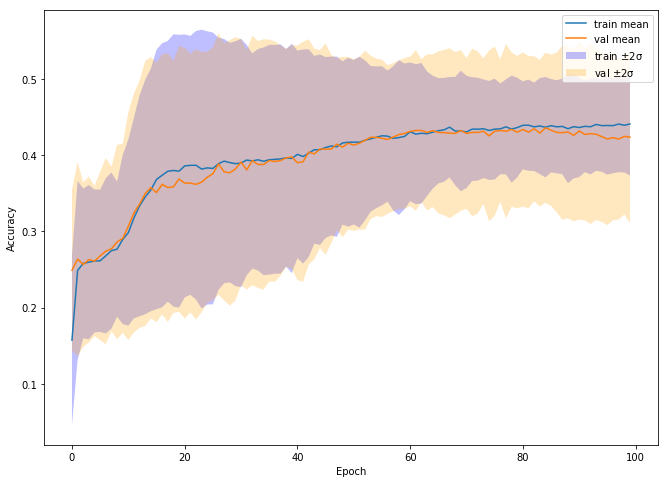

In [21]:
plot_stats('Accuracy', acc_history, val_acc_history)

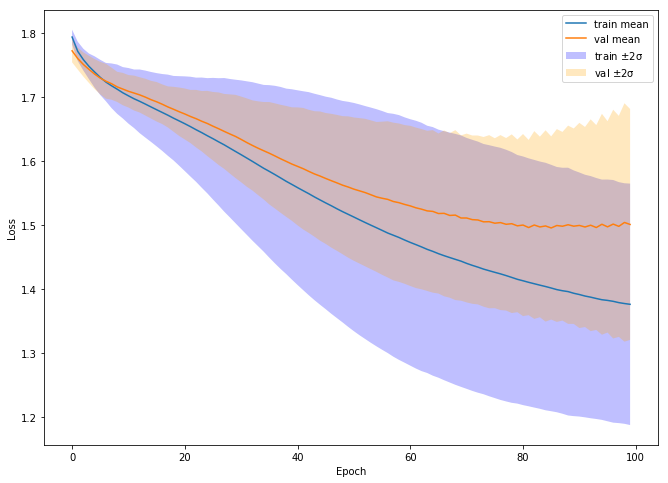

In [22]:
plot_stats('Loss', loss_history, val_loss_history)